Prueba de progreso 2

Imports

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.stats import variation
import seaborn as sns
import matplotlib.pyplot as plt

Carga de datos

In [2]:

# Ruta de la carpeta que contiene los ficheros
ruta_carpeta = 'dataset/data'

# Lista para almacenar los DataFrames
dataframes = []

# Recorrer todos los subdirectorios y archivos en la carpeta
for subdir, _, files in os.walk(ruta_carpeta):
    for file in files:
        if file.endswith('.csv'):  # Asegurarse de procesar solo archivos CSV
            # Construir la ruta completa del archivo
            ruta_archivo = os.path.join(subdir, file)
            
            # Extraer información del sujeto y la grabación del nombre del archivo y la ruta
            partes = subdir.split(os.sep)
            sujeto = partes[-1]  # Nombre del sujeto (última carpeta)
            grabacion = file.split('.')[0]  # Nombre de la grabación (sin extensión)
            
            # Cargar el archivo CSV en un DataFrame
            df = pd.read_csv(ruta_archivo)
            
            # Agregar columnas para identificar el sujeto y la grabación
            df['Sujeto'] = sujeto
            df['Grabacion'] = grabacion
            
            # Agregar el DataFrame a la lista
            dataframes.append(df)

# Combinar todos los DataFrames en uno solo
datos_combinados = pd.concat(dataframes, ignore_index=True)

# Mostrar las primeras filas del DataFrame combinado
print(datos_combinados.head())

   pelvis_x   pelvis_y  pelvis_z      L5_x       L5_y      L5_z      L3_x  \
0  5.290658  10.270959  0.928399  5.295636  10.278010  1.024168  5.294113   
1  5.290281  10.270359  0.928462  5.295316  10.277418  1.024227  5.293876   
2  5.289904  10.269758  0.928525  5.294997  10.276826  1.024286  5.293640   
3  5.289517  10.269149  0.928582  5.294664  10.276223  1.024340  5.293392   
4  5.289107  10.268520  0.928633  5.294305  10.275599  1.024388  5.293121   

        L3_y      L3_z     T12_x  ...  footLeft_y  footLeft_z  toeLeft_x  \
0  10.278961  1.128732  5.299640  ...   10.221425    0.094657   5.295842   
1  10.278291  1.128793  5.299482  ...   10.221376    0.094694   5.295831   
2  10.277622  1.128854  5.299325  ...   10.221327    0.094731   5.295820   
3  10.276951  1.128909  5.299158  ...   10.221278    0.094760   5.295819   
4  10.276274  1.128959  5.298974  ...   10.221229    0.094778   5.295838   

   toeLeft_y  toeLeft_z     vel_x     vel_y     vel_z  Sujeto  Grabacion  
0  10

Eliminar correlación entre articulaciones

In [4]:
# Copia del DataFrame original
resta = datos_combinados.iloc[:, :-2].copy()  # Excluir las dos últimas columnas

# Itera de tres en tres columnas, comenzando desde la cuarta columna
for i in range(3, resta.shape[1], 3):  # Empieza en la columna 3 y avanza de 3 en 3
    if i + 3 <= resta.shape[1]:  # Verificar que no exceda el número de columnas
        resta.iloc[:, i:i+3] -= datos_combinados.iloc[:, 0:3].values  # Resta las columnas X, Y, Z de la pelvis

# Ahora vamos a afinar un poco más
resta2 = resta.copy()
for j in range(67, 67+3, 1):  # Tiene en cuenta las partes del cuerpo que dependen de otras, no solo de la pelvis
    if j < resta2.shape[1]:  # Verificar que no exceda el número de columnas
        resta2.iloc[:, j] -= resta2.iloc[:, j-3].values
        if j-12 >= 0:  # Verificar índices válidos
            resta2.iloc[:, j-12] -= resta2.iloc[:, j-3-12].values
        if j-24 >= 0:
            resta2.iloc[:, j-24] -= resta2.iloc[:, j-3-24].values
        if j-36 >= 0:
            resta2.iloc[:, j-36] -= resta2.iloc[:, j-3-36].values

for j in range(19, 19+3, 1):
    if j < resta2.shape[1]:  # Verificar que no exceda el número de columnas
        resta2.iloc[:, j] -= resta2.iloc[:, j-3].values

Ventaneo

In [5]:
freq =60
segundos = 4
ventana = freq*segundos
a=[]
for i in range(0,len(resta)-ventana+1, ventana):
  a.append(resta.iloc[i:i+ventana])

Normalización

In [11]:
# Normalización de los puntos de cada persona
scaler = StandardScaler()
resta_normalizada = pd.DataFrame(scaler.fit_transform(resta), columns=resta.columns)

# Normalización de las rutas en cada ventana
for ventana_df in a:
    # Restar la posición inicial de la pelvis (x, y, z) a todas las columnas correspondientes
    pelvis_inicial = ventana_df.iloc[0, :3].values  # Coordenadas iniciales de la pelvis
    ventana_df.iloc[:, :3] -= pelvis_inicial  # Normalizar pelvis
    for i in range(3, ventana_df.shape[1], 3):  # Iterar sobre las columnas de las articulaciones
        ventana_df.iloc[:, i:i+3] -= pelvis_inicial

C:\Users\Usuario\AppData\Local\Temp\ipykernel_412\222788606.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ventana_df.iloc[:, :3] -= pelvis_inicial  # Normalizar pelvis
C:\Users\Usuario\AppData\Local\Temp\ipykernel_412\222788606.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ventana_df.iloc[:, i:i+3] -= pelvis_inicial


Extracción de características

In [12]:
# Extracción de características por cada articulación y ventana
def calcular_energia(signal):
    return np.sum(signal ** 2) / len(signal)

def calcular_parametros_hjorth(signal):
    diff_signal = np.diff(signal)
    diff2_signal = np.diff(diff_signal)
    var_signal = np.var(signal)
    var_diff_signal = np.var(diff_signal)
    var_diff2_signal = np.var(diff2_signal)

    actividad = var_signal
    movilidad = np.sqrt(var_diff_signal / var_signal)
    complejidad = np.sqrt(var_diff2_signal / var_diff_signal) / movilidad

    return actividad, movilidad, complejidad

caracteristicas = []

for ventana_df in a:
    caracteristicas_ventana = {}
    for columna in ventana_df.columns:
        signal = ventana_df[columna].values
        
        # Calcular características
        media = np.mean(signal)
        desviacion = np.std(signal)
        minimo = np.min(signal)
        maximo = np.max(signal)
        energia = calcular_energia(signal)
        actividad, movilidad, complejidad = calcular_parametros_hjorth(signal)

        # Guardar características
        caracteristicas_ventana[columna] = {
            'media': media,
            'desviacion': desviacion,
            'minimo': minimo,
            'maximo': maximo,
            'energia': energia,
            'actividad': actividad,
            'movilidad': movilidad,
            'complejidad': complejidad
        }
    caracteristicas.append(caracteristicas_ventana)

Elección de algoritmo

Simplicidad y eficiencia: K-Means es un algoritmo sencillo y eficiente para conjuntos de datos de tamaño moderado, como el que estás manejando.

Datos numéricos: Tus datos (características extraídas como media, desviación típica, energía, etc.) son numéricos, lo que se adapta bien a K-Means, que utiliza distancias euclidianas para agrupar.

Interpretabilidad: Los resultados de K-Means son fáciles de interpretar, ya que cada punto pertenece a un único clúster.

Escalabilidad: K-Means puede manejar un número razonable de ventanas y articulaciones, lo que parece ser el caso en tu proyecto.

Consideraciones:

Número de clústeres: Es necesario determinar el número óptimo de clústeres (k). Esto se puede hacer utilizando el método del codo (elbow method) o el índice de silueta.

Normalización previa: Dado que K-Means es sensible a la escala de los datos, es importante que los datos estén normalizados, lo cual ya has implementado.

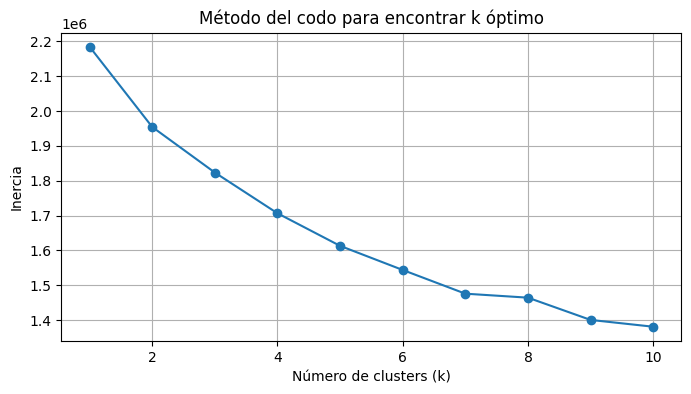

Etiquetas de clusters por ventana:
[0 2 2 ... 2 2 2]


In [13]:
# --- Convertir características en matriz 2D ---
filas = []
for ventana in caracteristicas:
    fila = []
    for joint, features in ventana.items():
        fila.extend(features.values())  # Agrega todas las características numéricas
    filas.append(fila)

X = np.array(filas)

# --- Normalización ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Elegir número óptimo de clusters (método del codo) ---
inercia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inercia.append(kmeans.inertia_)

# Graficar método del codo
plt.figure(figsize=(8, 4))
plt.plot(k_range, inercia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del codo para encontrar k óptimo')
plt.grid(True)
plt.show()

# --- Aplicar KMeans con k óptimo (por ejemplo, 3) ---
k_optimo = 3  # Cambia este valor según el codo
kmeans_final = KMeans(n_clusters=k_optimo, random_state=0)
labels = kmeans_final.fit_predict(X_scaled)

# labels contiene el número de cluster asignado a cada ventana
print("Etiquetas de clusters por ventana:")
print(labels)

Interpretación de resultados

In [14]:
# Convertimos X_scaled nuevamente a DataFrame con nombres de columnas
n_features = len(filas[0])
columnas = []

for joint in caracteristicas[0].keys():
    for feature in caracteristicas[0][joint].keys():
        columnas.append(f'{joint}_{feature}')

df_clusters = pd.DataFrame(X_scaled, columns=columnas)
df_clusters['cluster'] = labels

# Obtener estadísticas por grupo
resumen = df_clusters.groupby('cluster').agg(['mean', 'std'])
print("Resumen estadístico por cluster:")
print(resumen)


Resumen estadístico por cluster:
        pelvis_x_media           pelvis_x_desviacion            \
                  mean       std                mean       std   
cluster                                                          
0             0.011122  0.928317           -0.088493  1.094561   
1            -0.033137  1.005332           -0.022102  1.126633   
2             0.003766  1.086729            0.131202  0.746112   

        pelvis_x_minimo           pelvis_x_maximo           pelvis_x_energia  \
                   mean       std            mean       std             mean   
cluster                                                                        
0              0.089309  0.880710       -0.073015  0.944355        -0.021773   
1              0.018426  1.067019       -0.039182  0.970548         0.006433   
2             -0.130223  1.094270        0.120068  1.075992         0.025587   

                   ... vel_z_maximo           vel_z_energia            \
              st

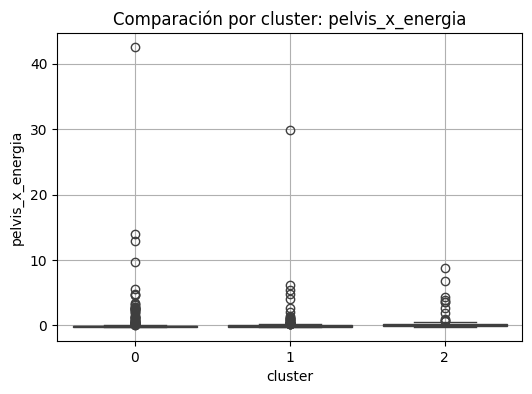

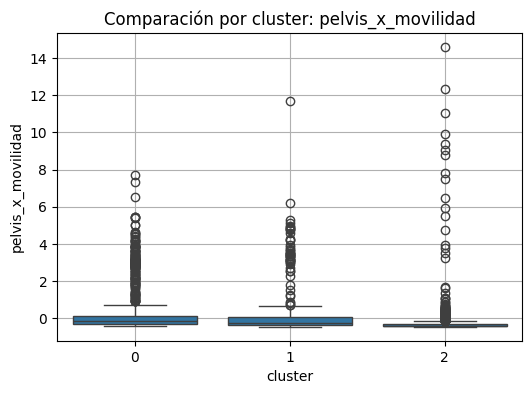

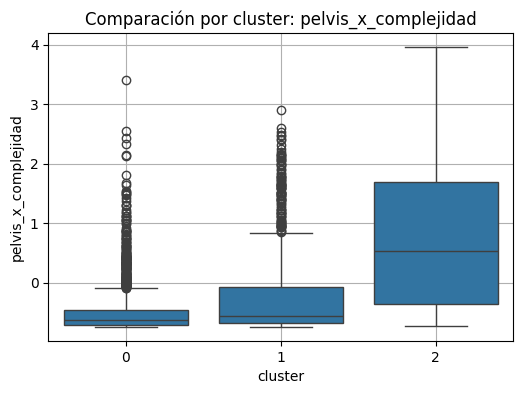

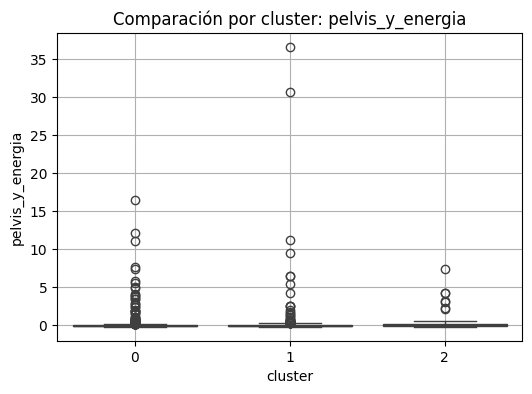

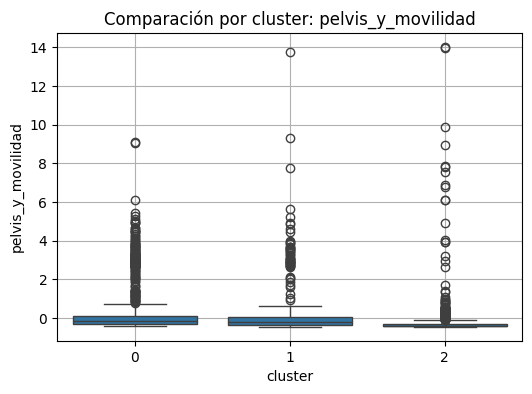

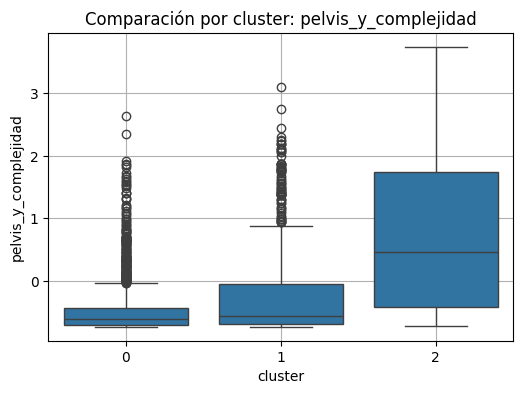

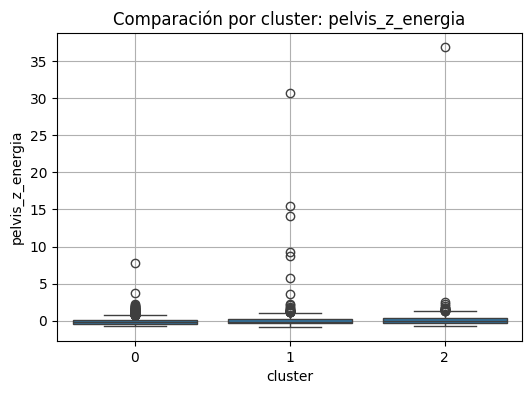

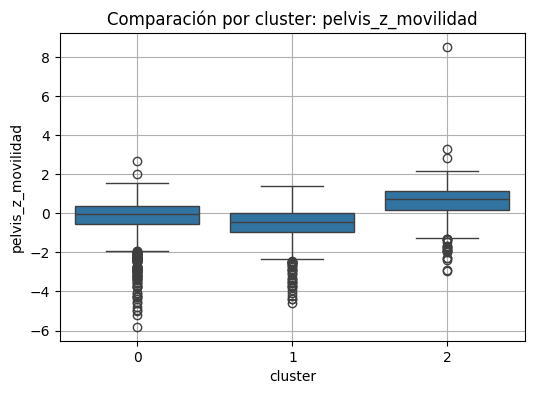

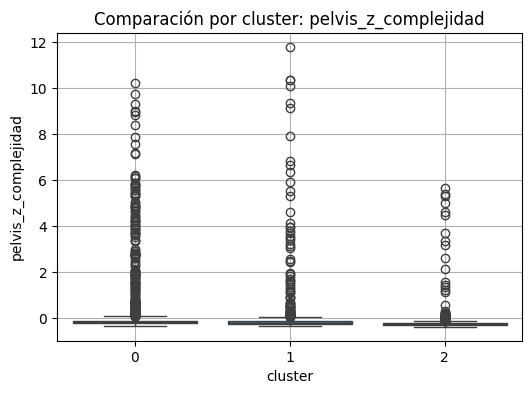

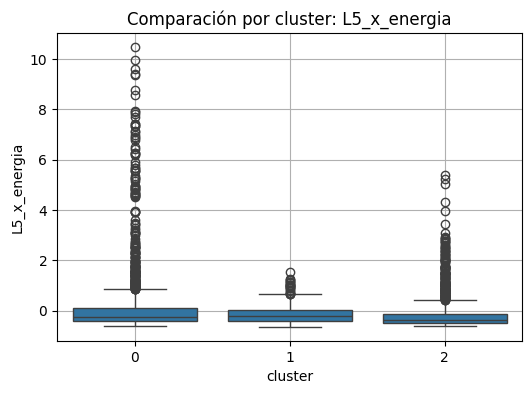

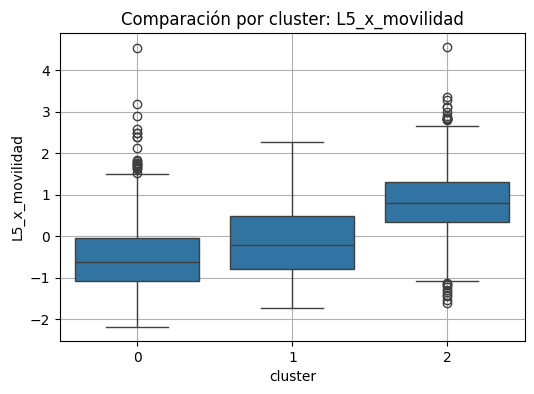

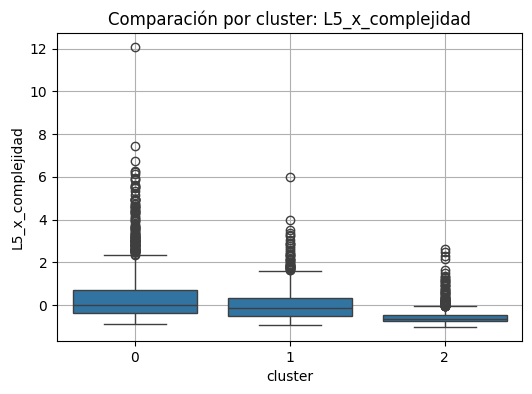

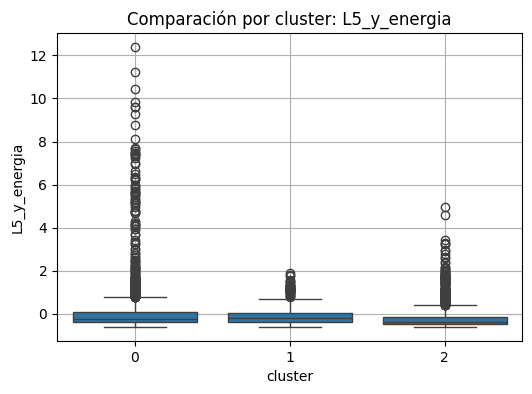

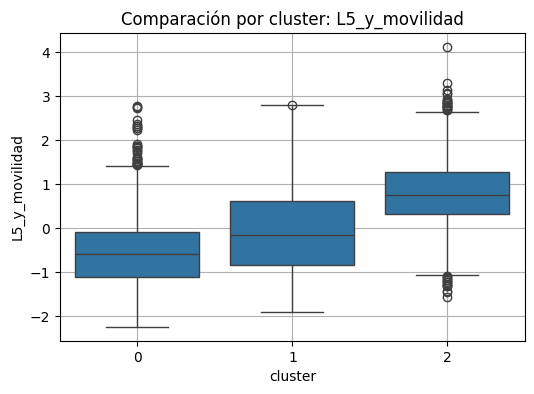

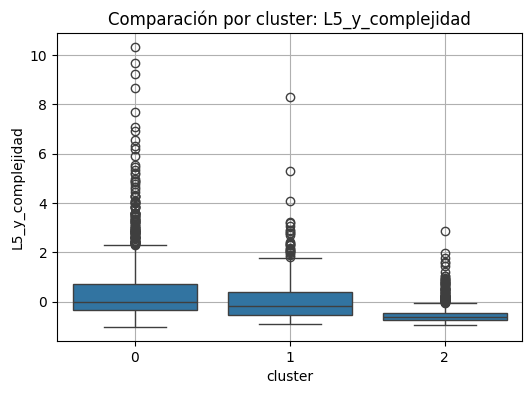

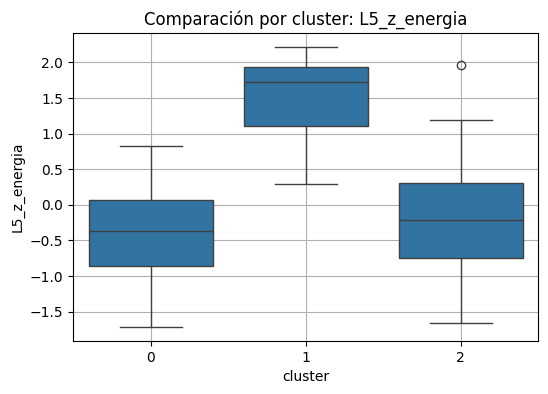

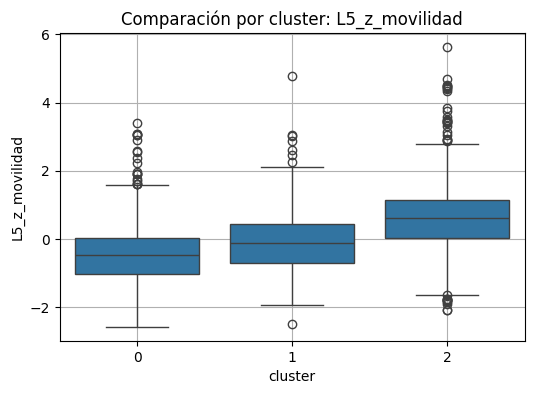

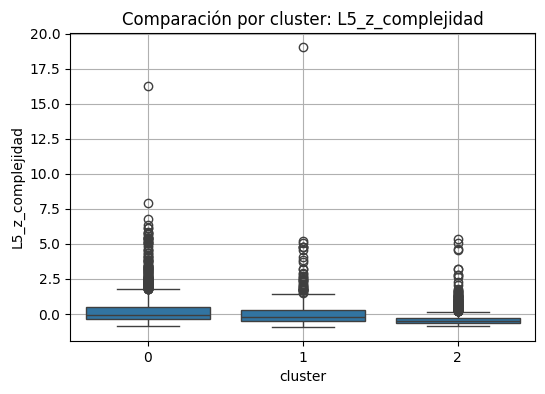

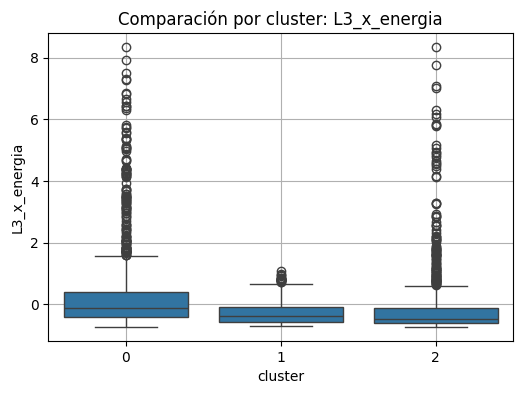

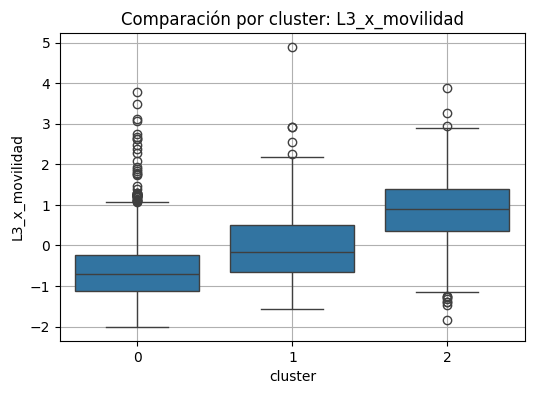

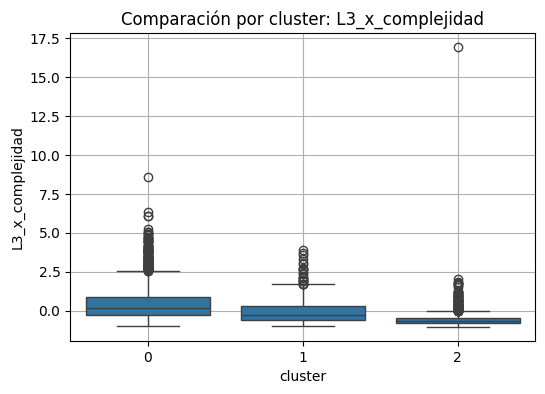

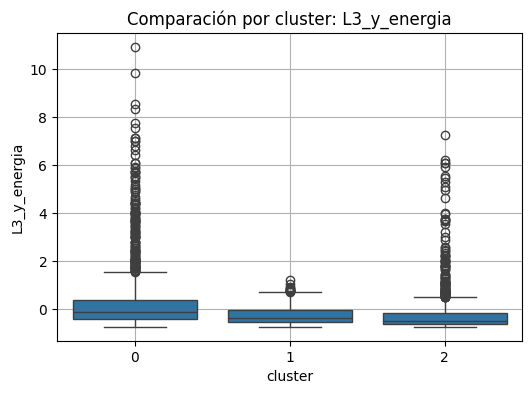

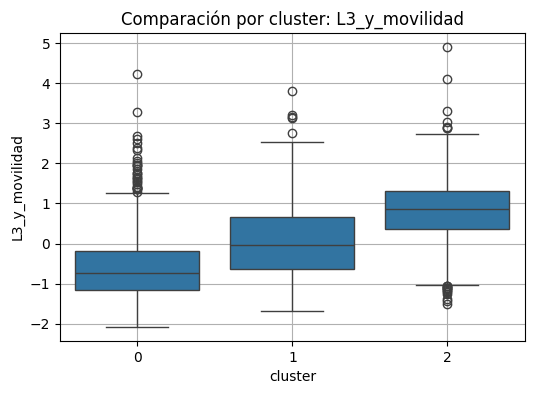

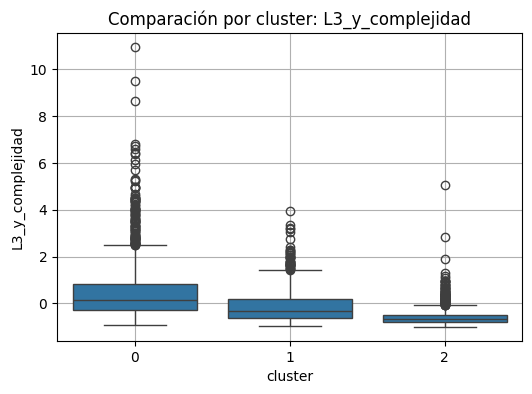

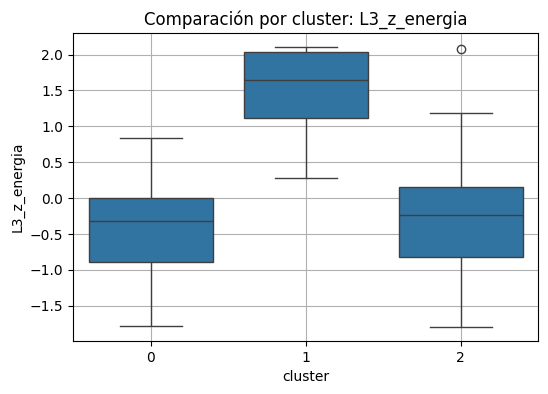

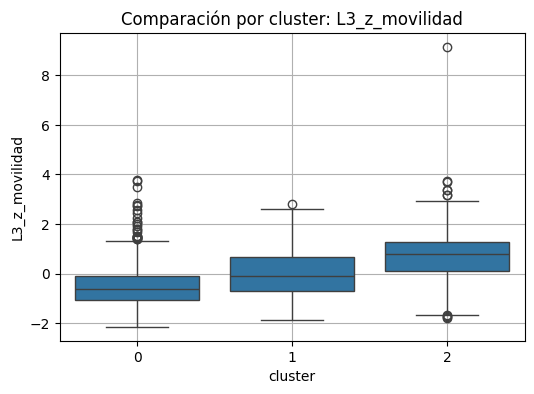

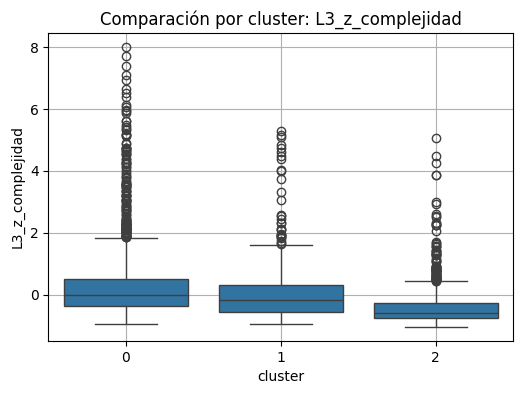

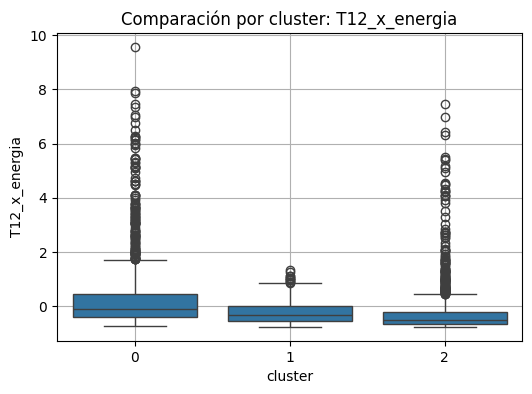

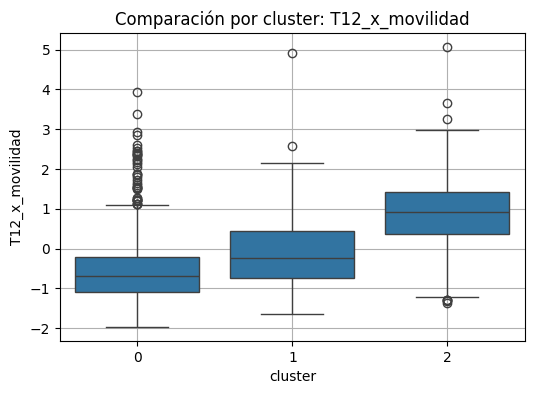

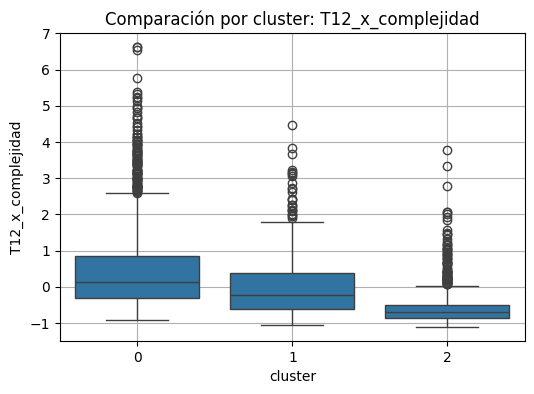

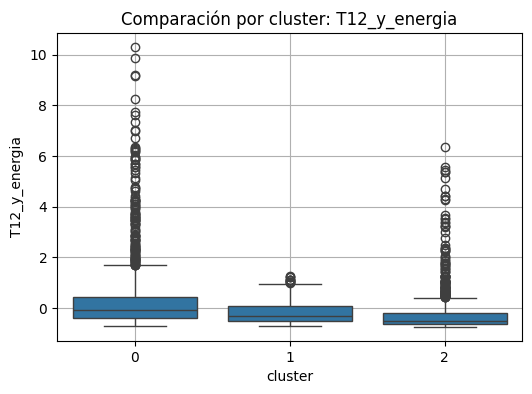

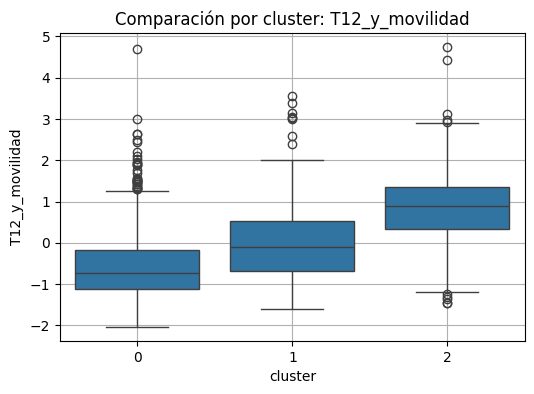

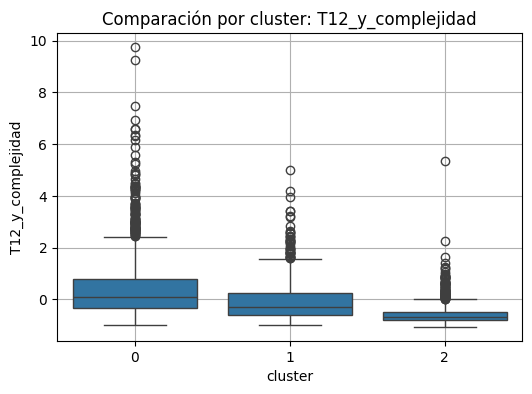

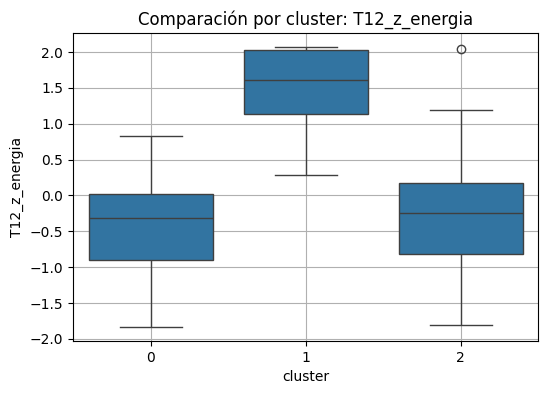

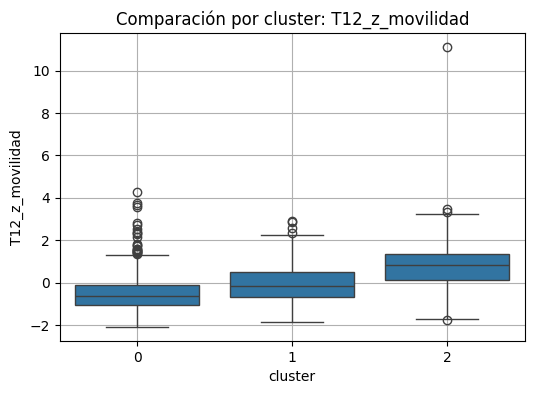

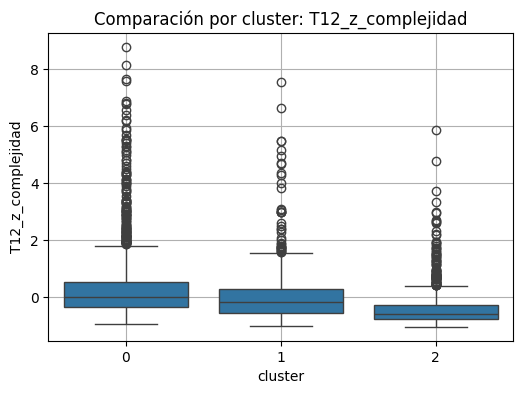

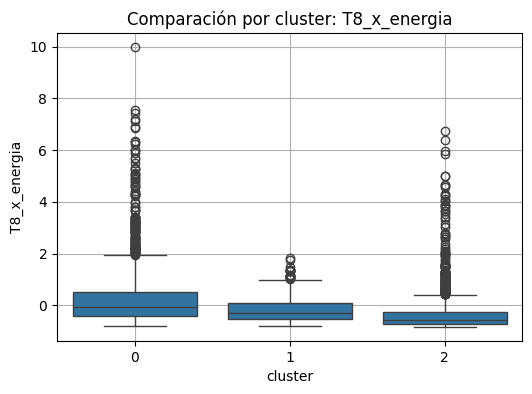

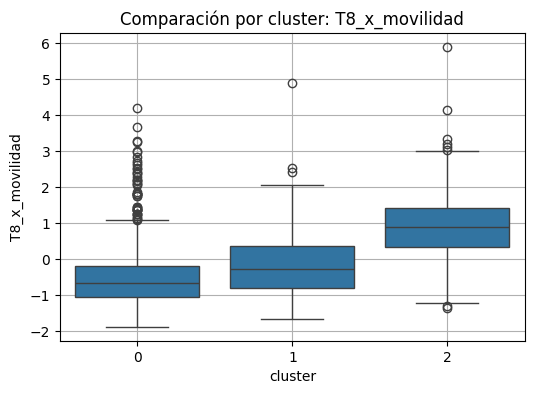

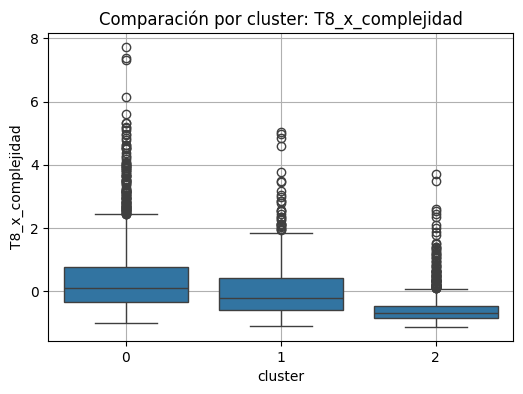

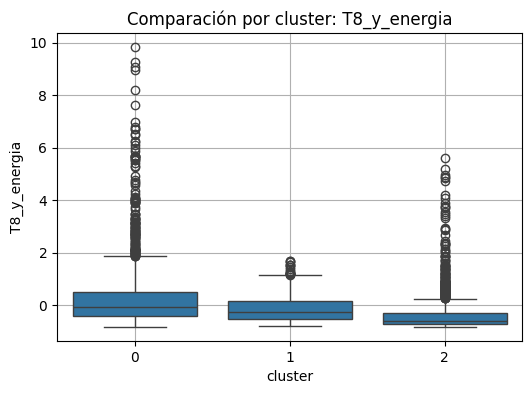

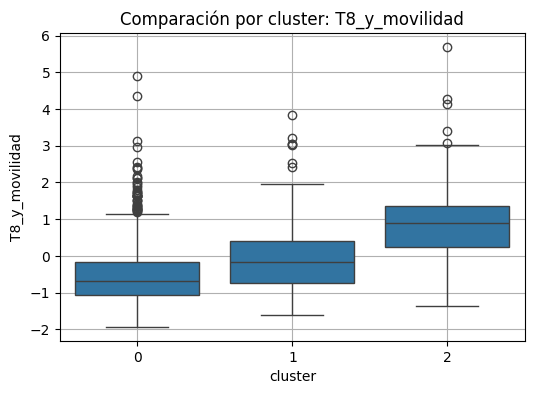

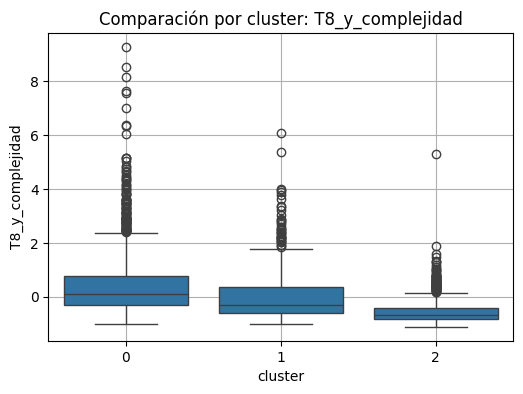

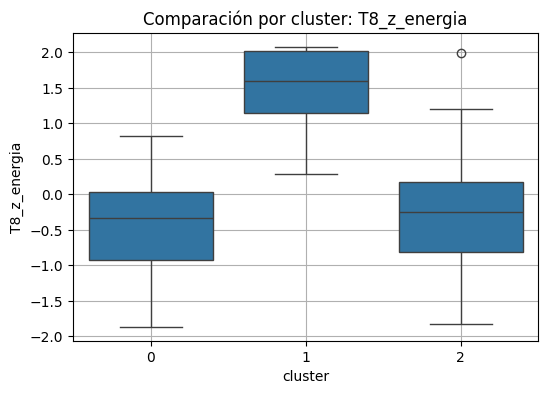

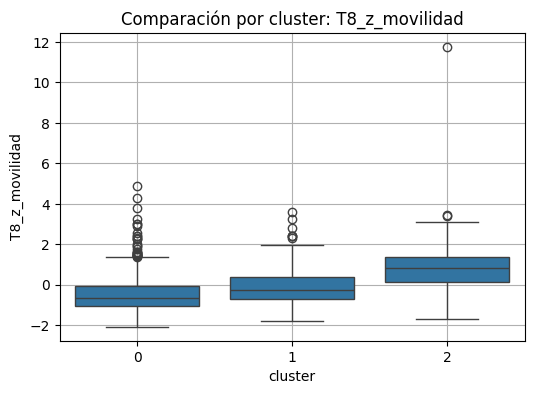

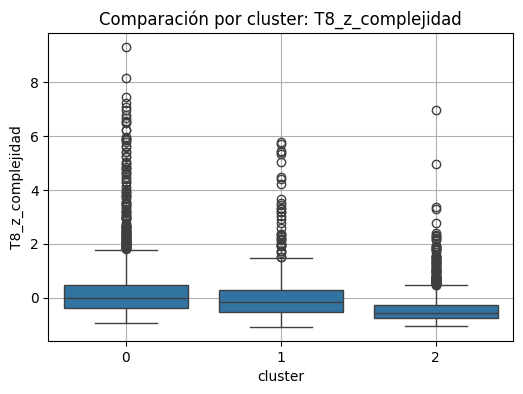

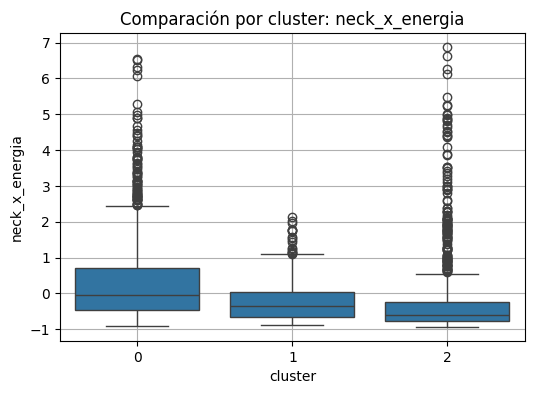

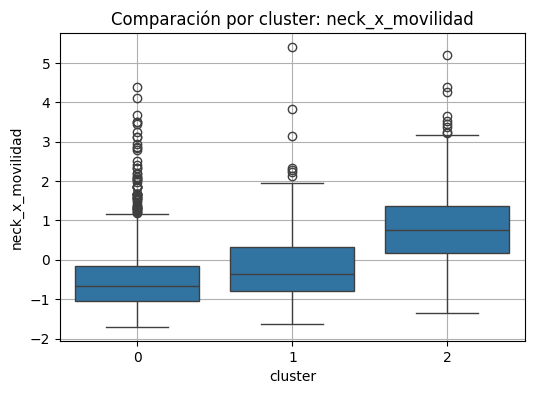

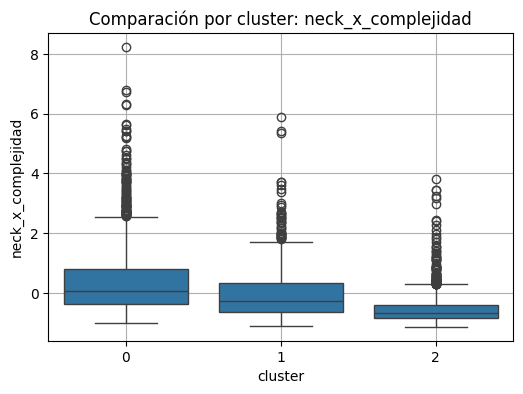

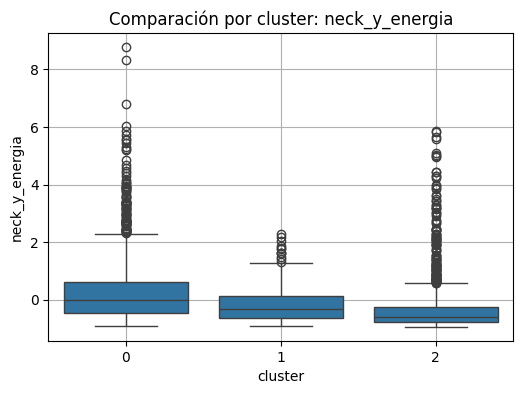

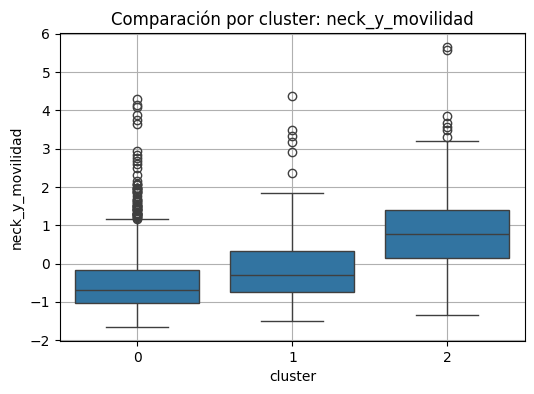

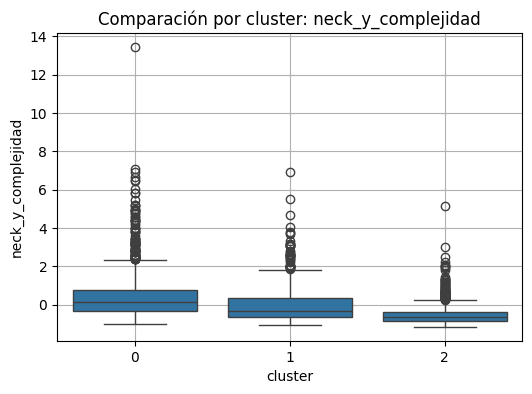

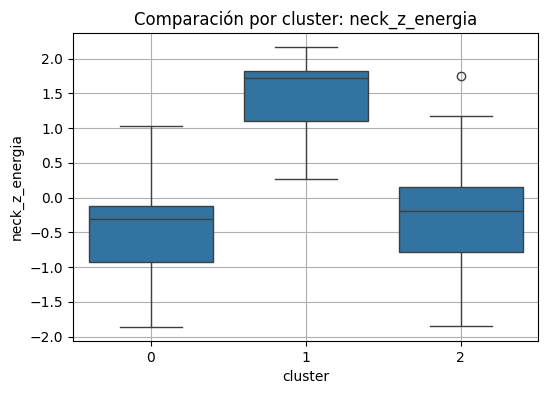

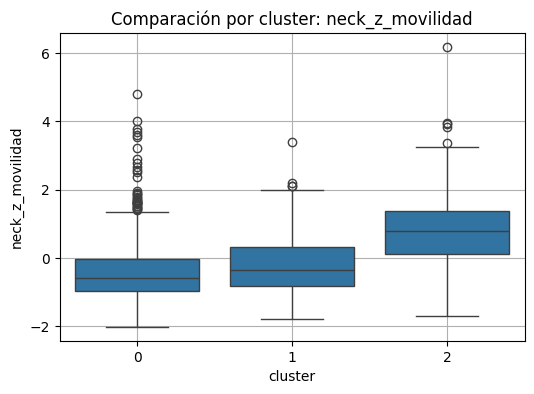

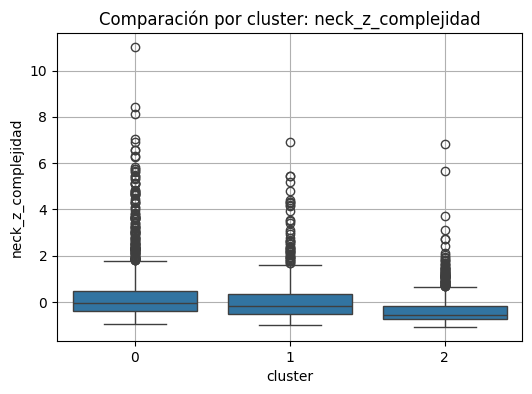

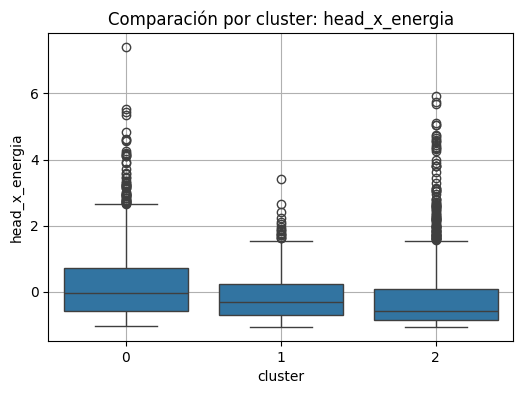

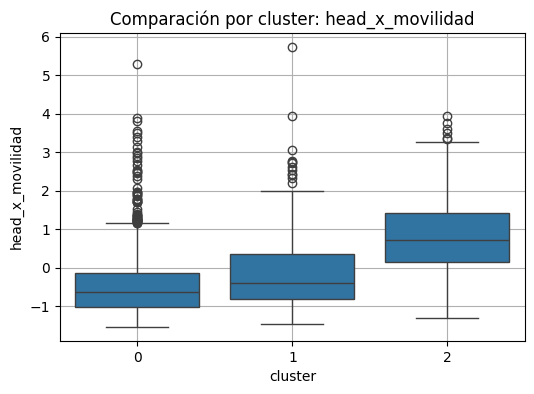

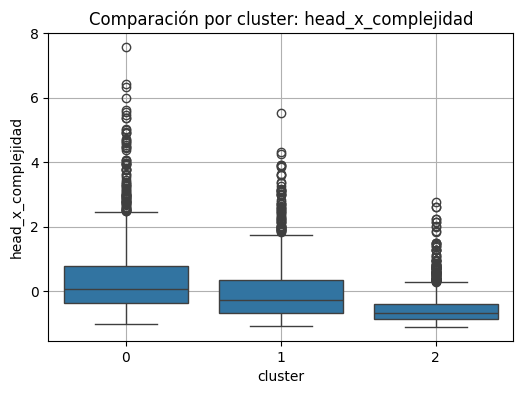

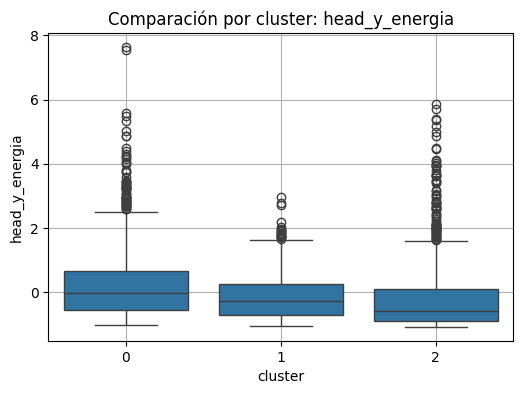

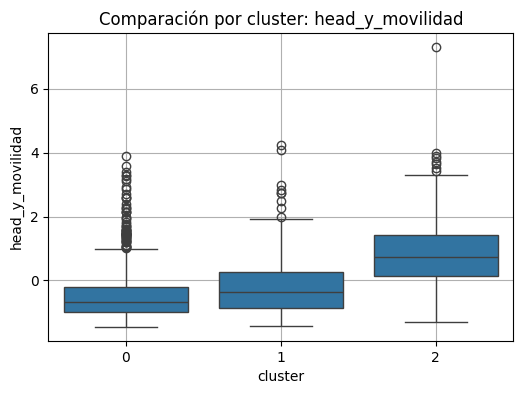

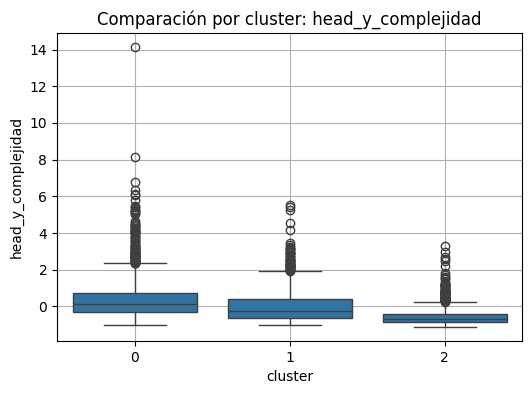

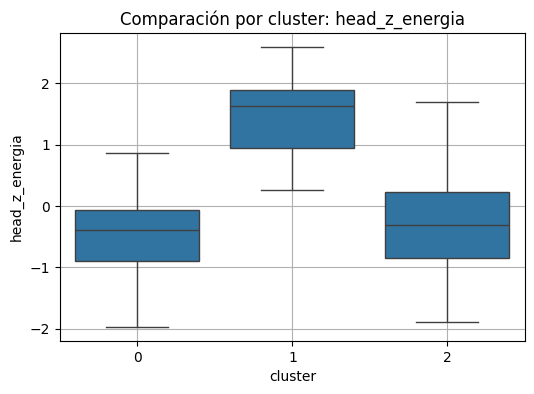

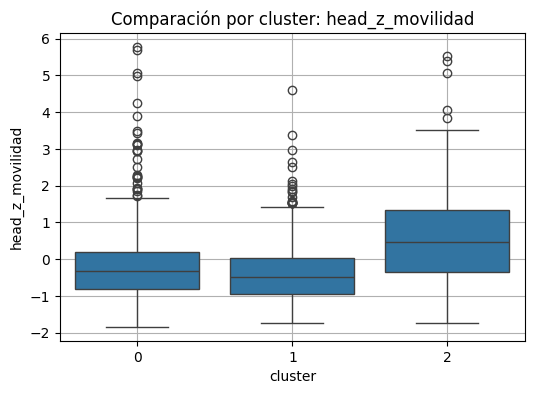

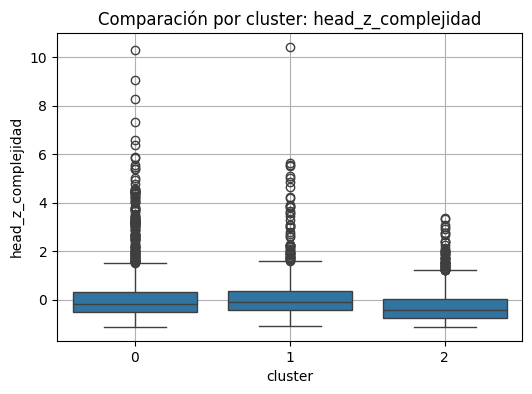

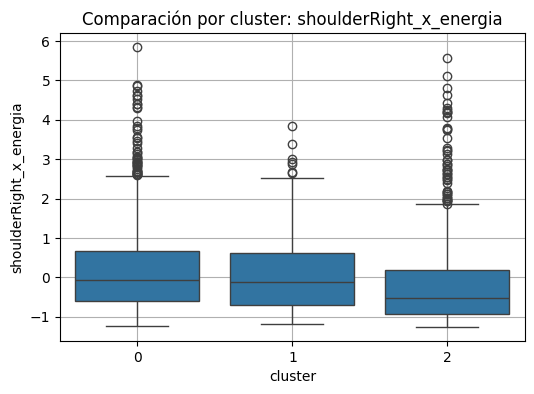

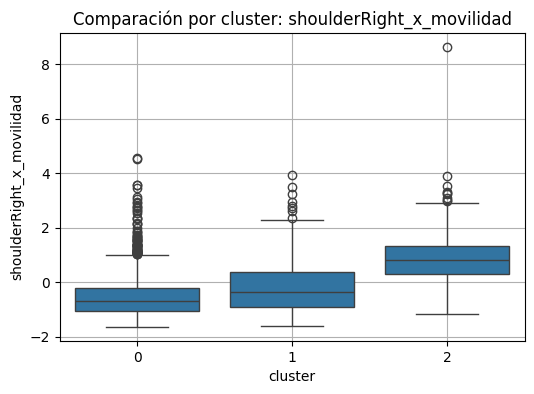

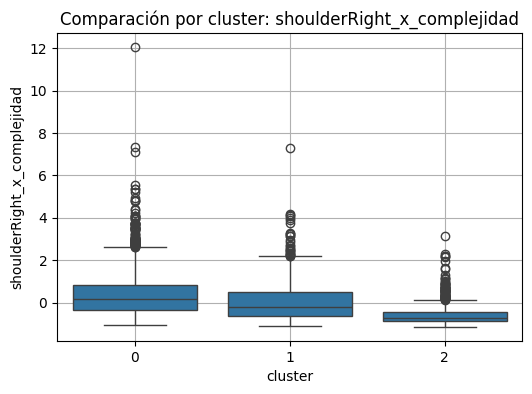

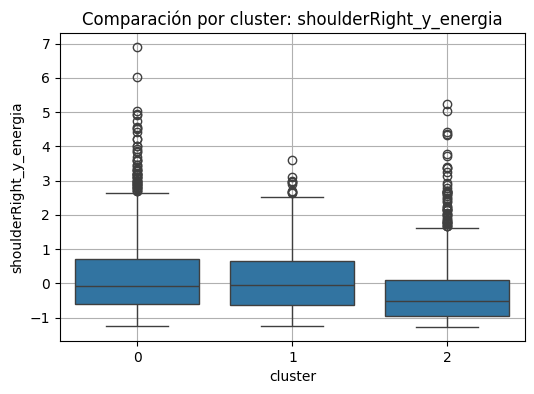

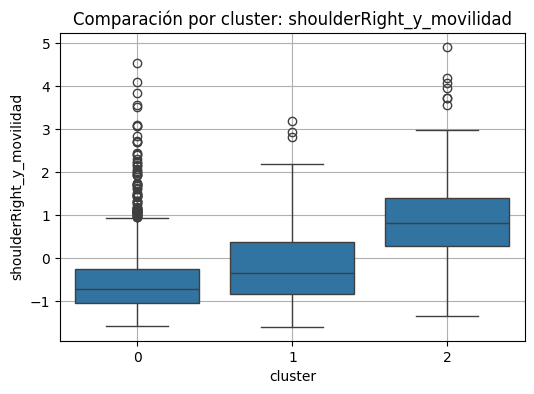

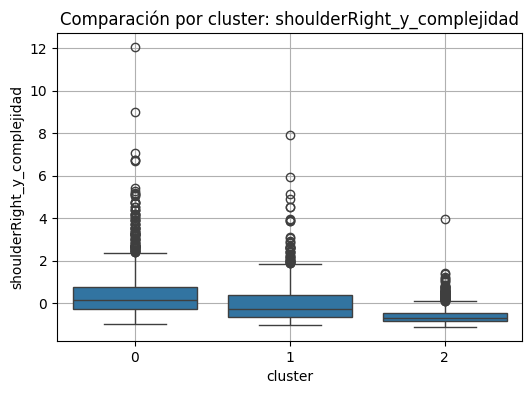

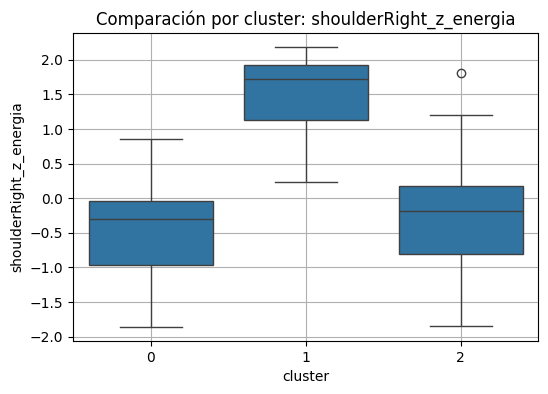

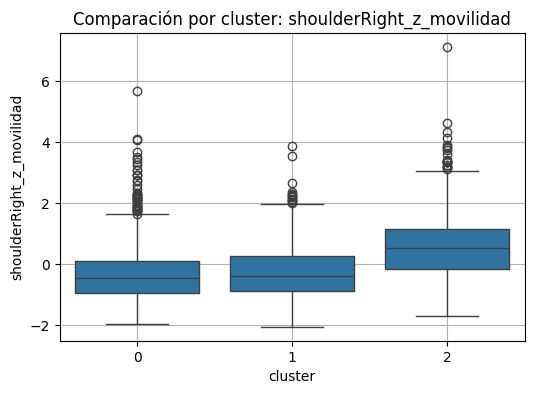

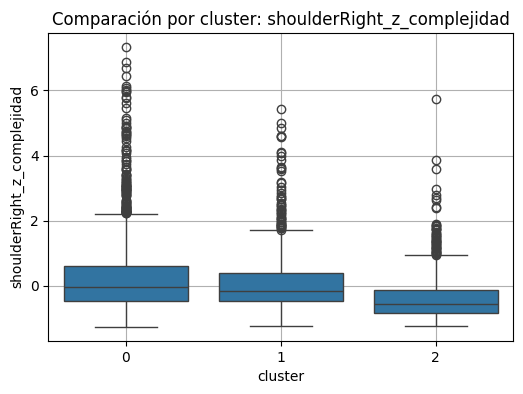

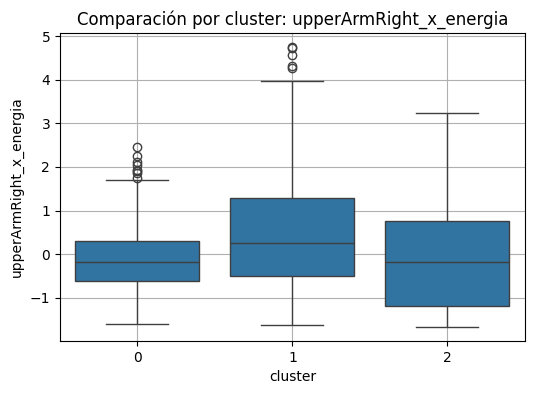

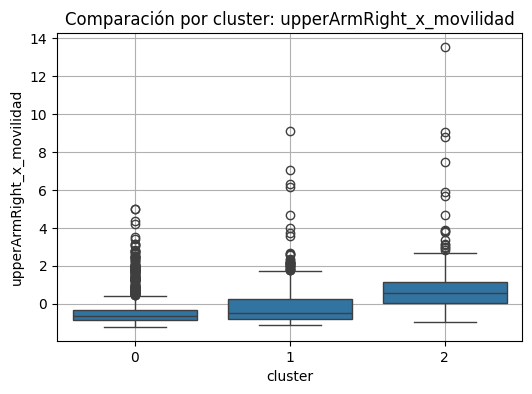

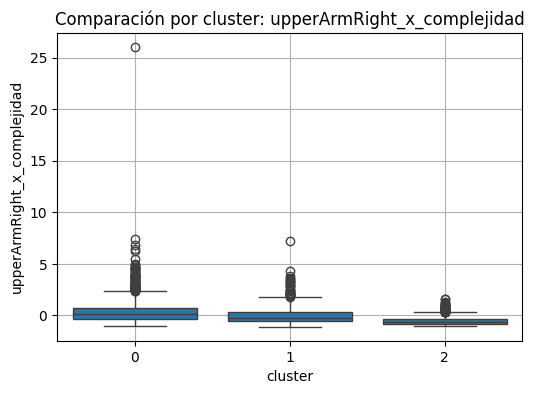

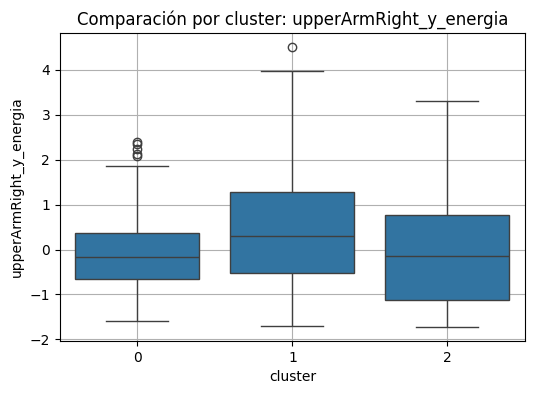

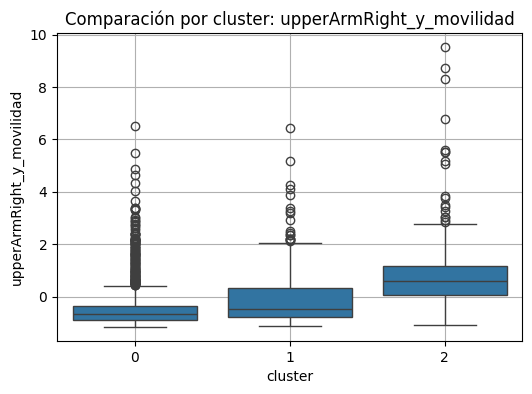

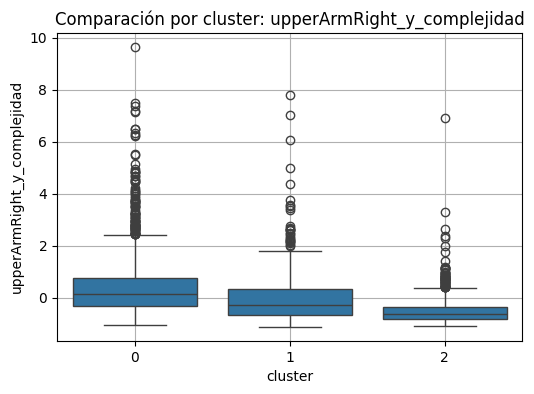

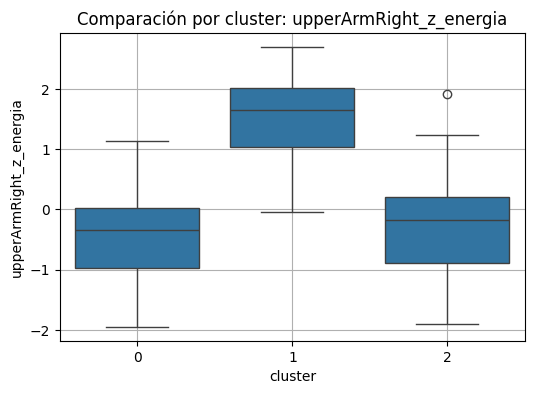

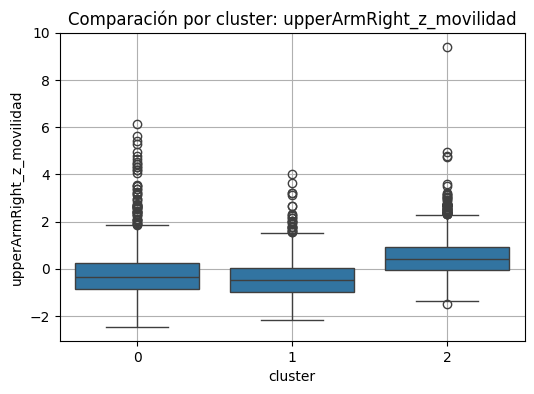

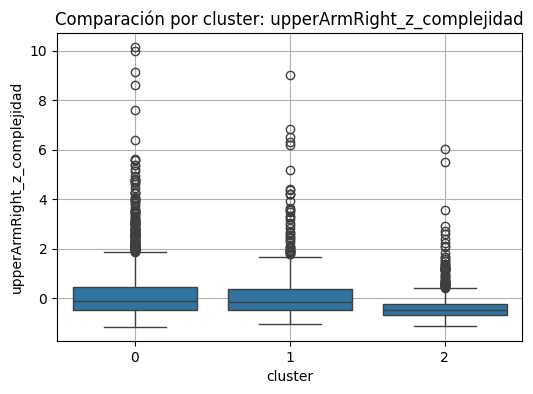

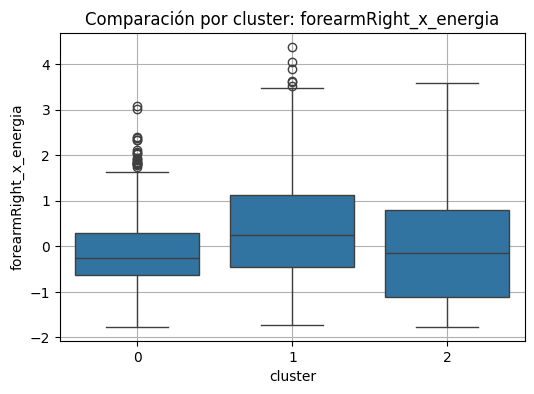

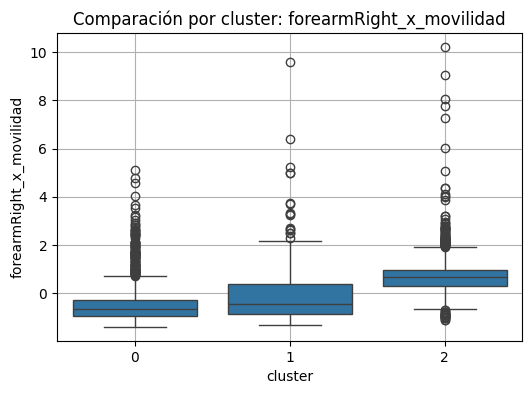

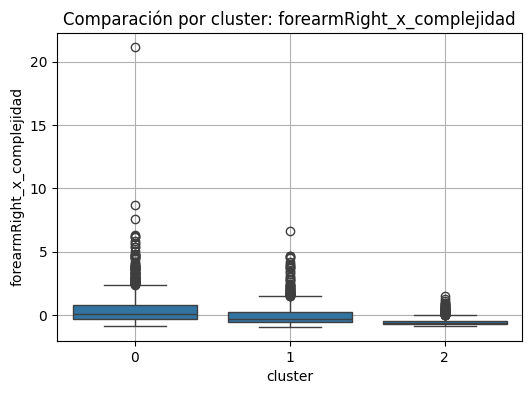

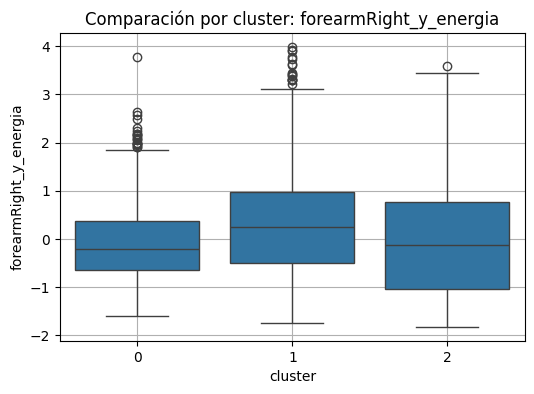

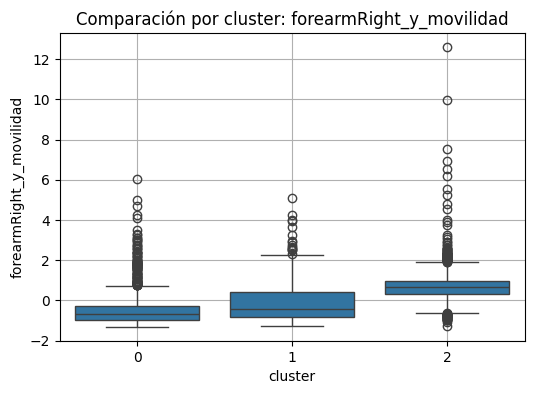

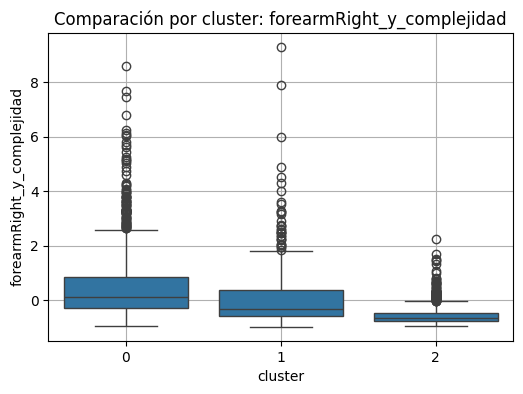

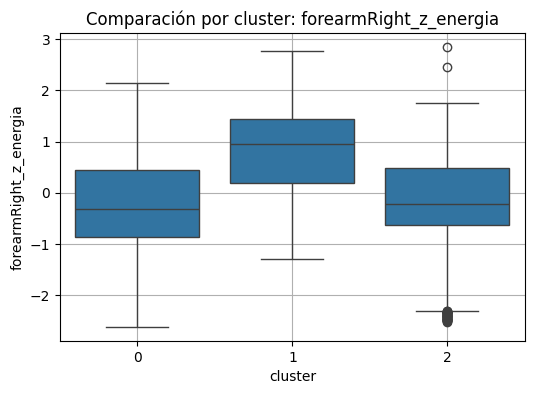

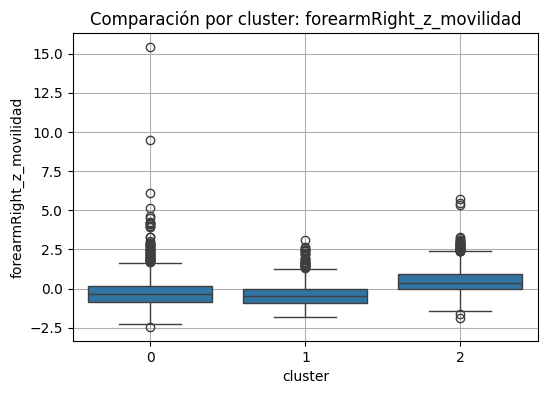

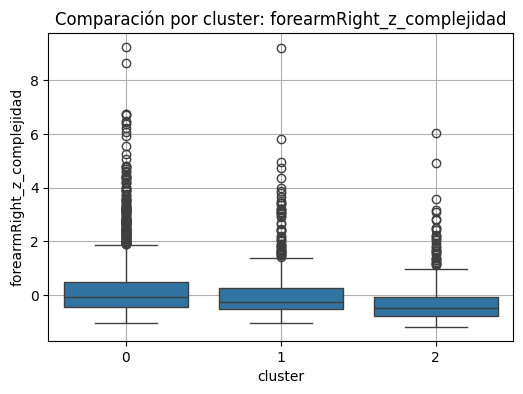

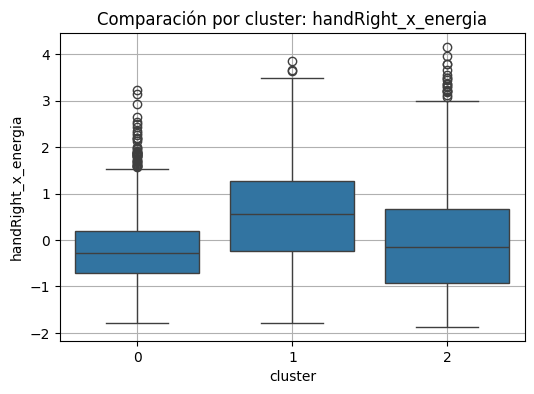

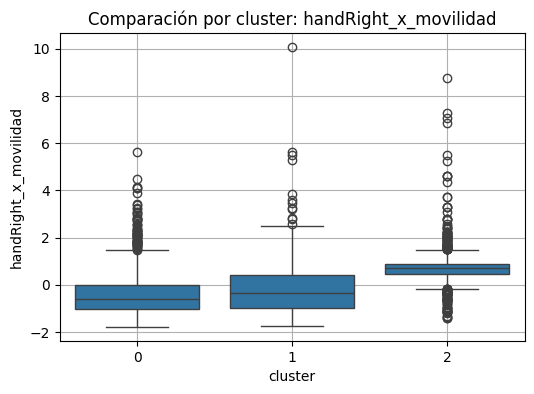

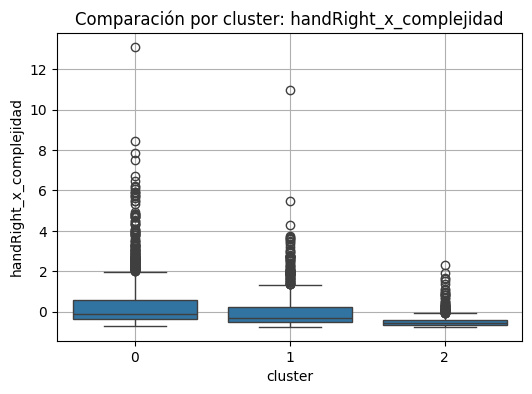

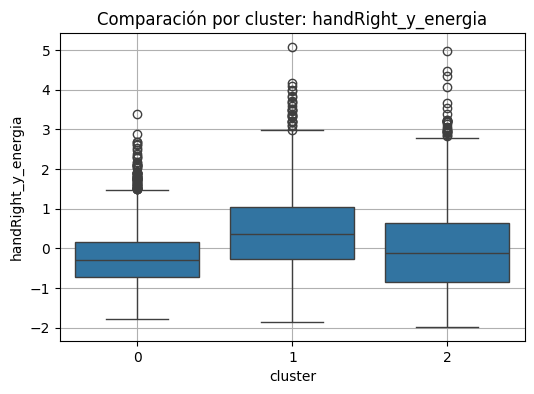

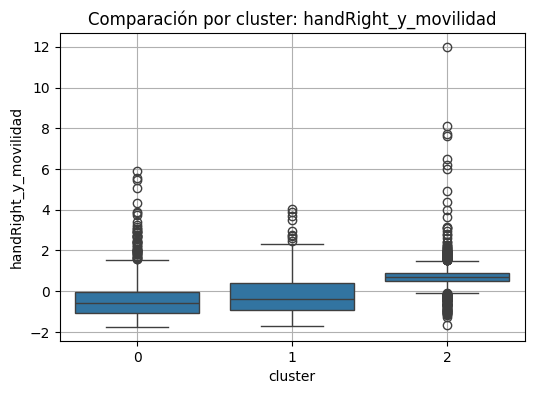

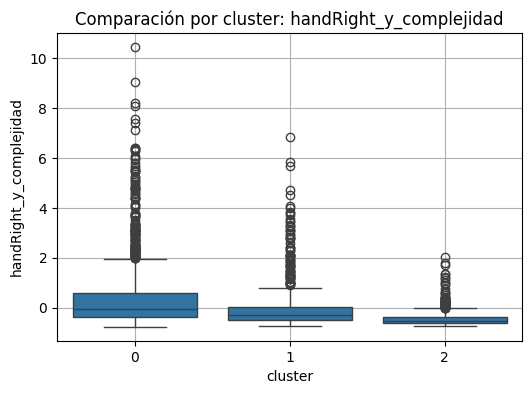

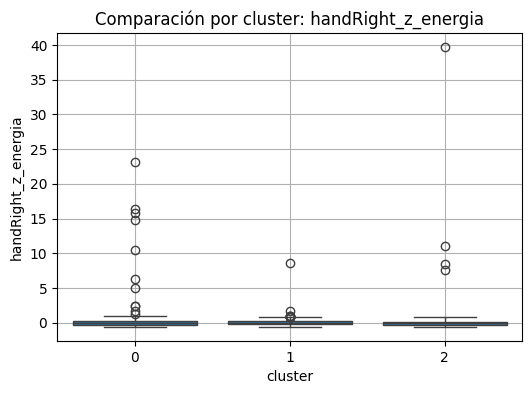

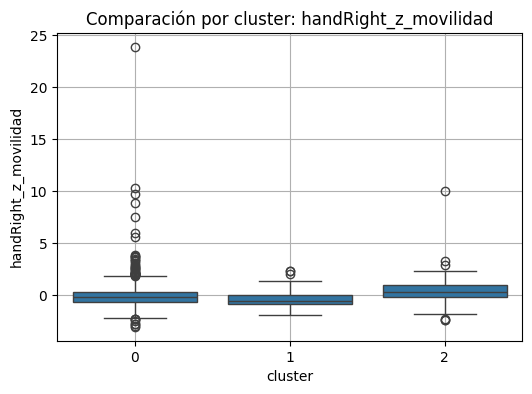

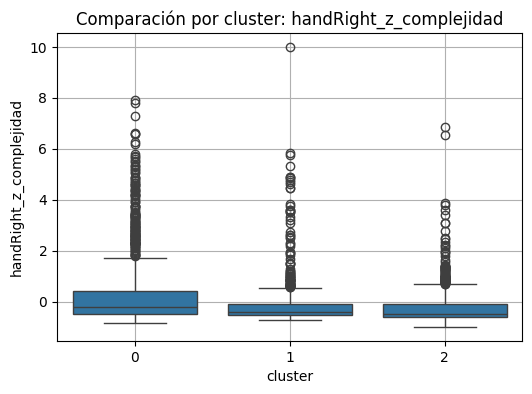

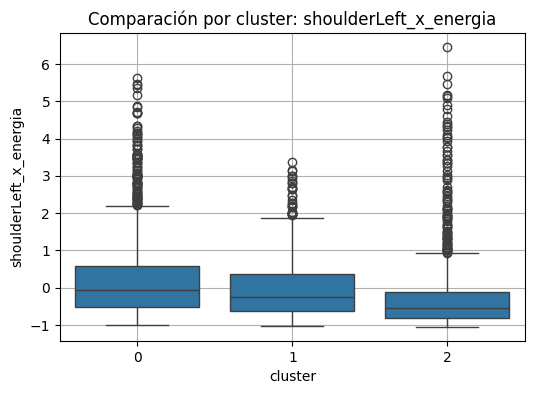

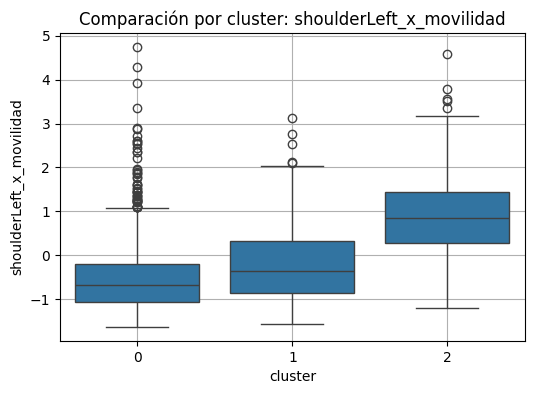

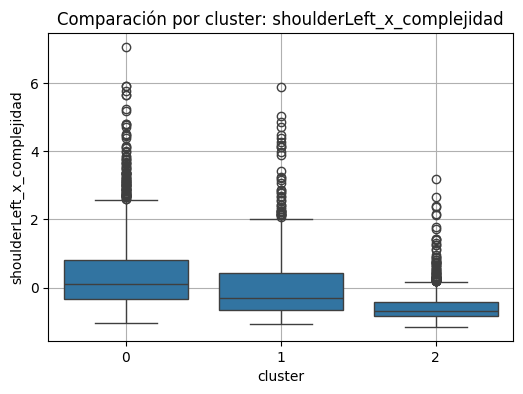

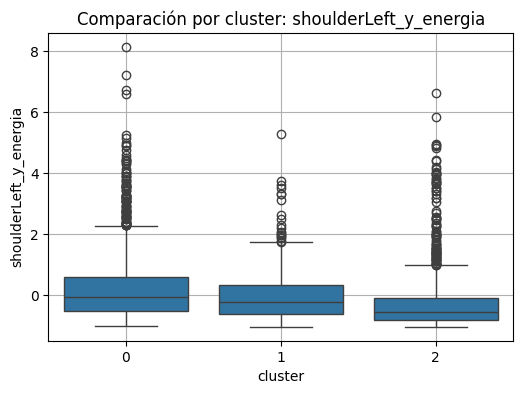

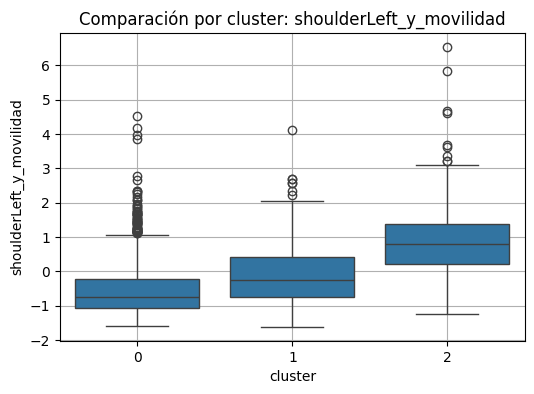

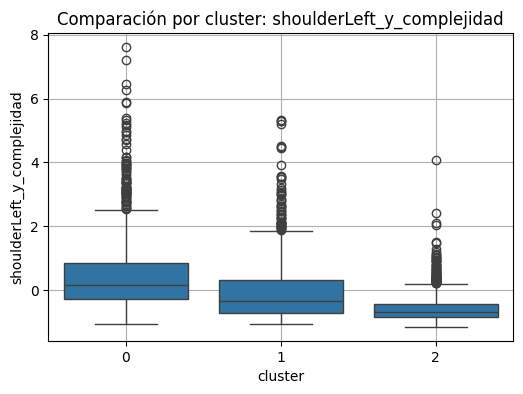

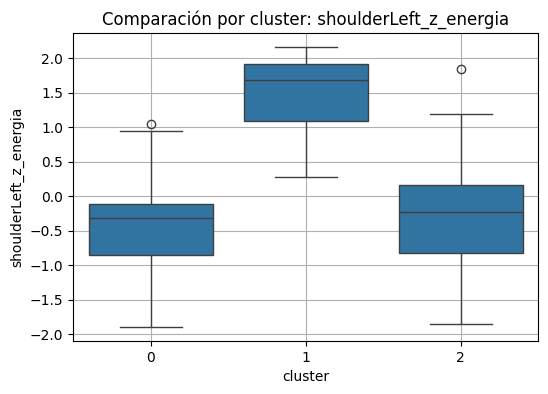

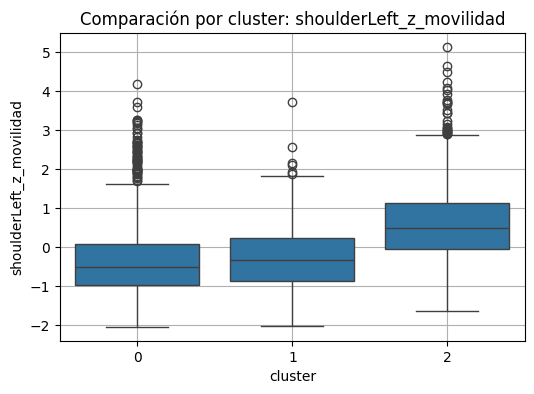

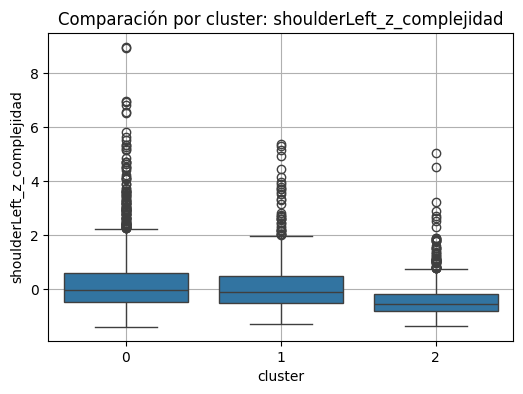

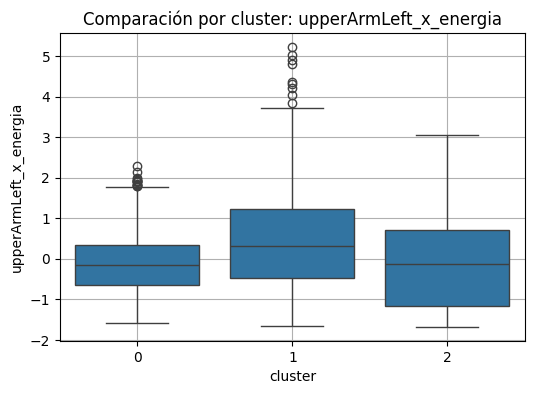

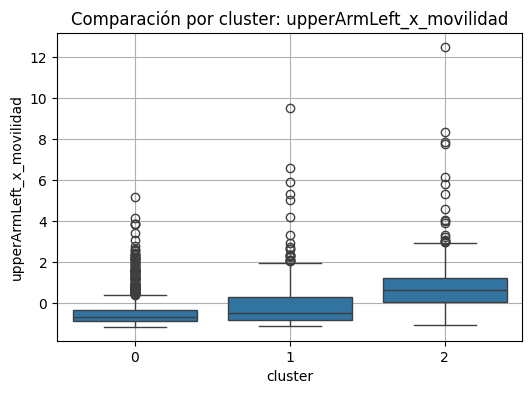

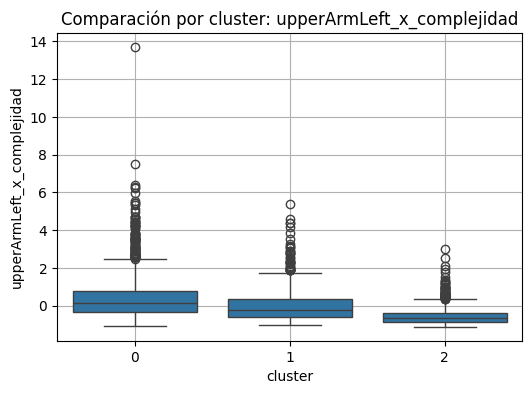

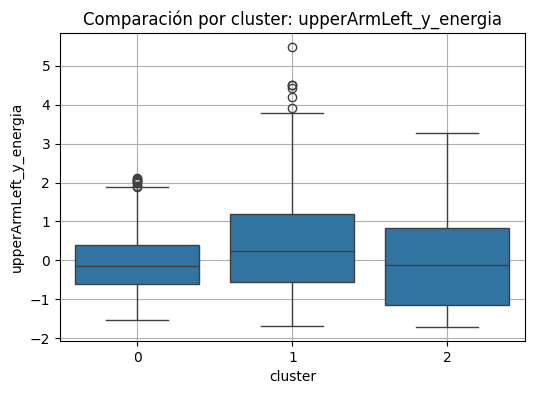

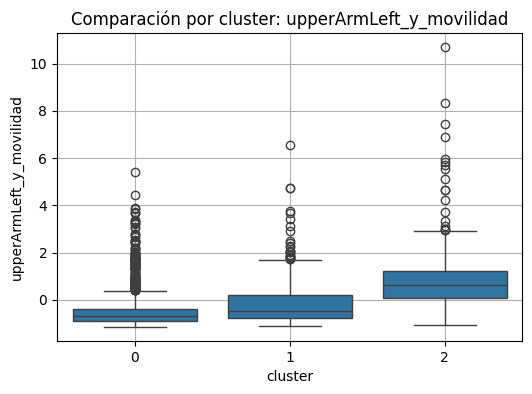

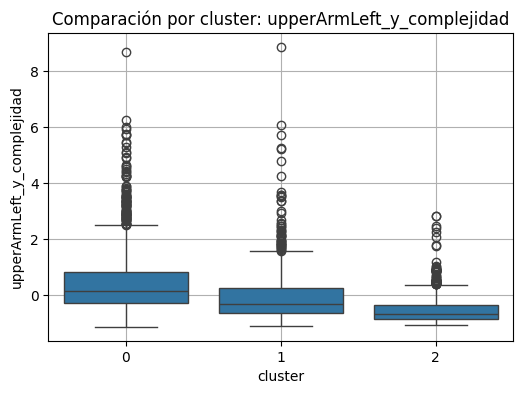

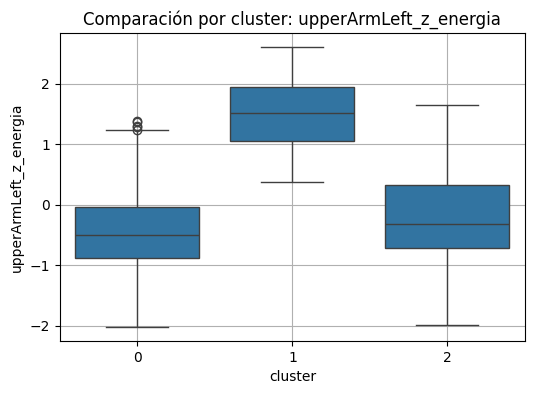

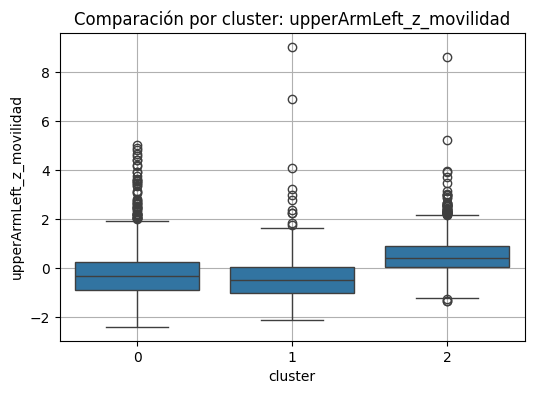

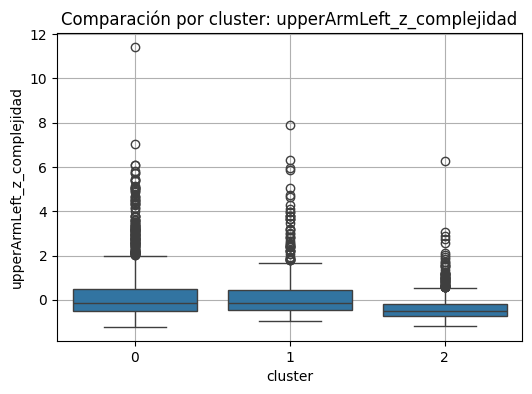

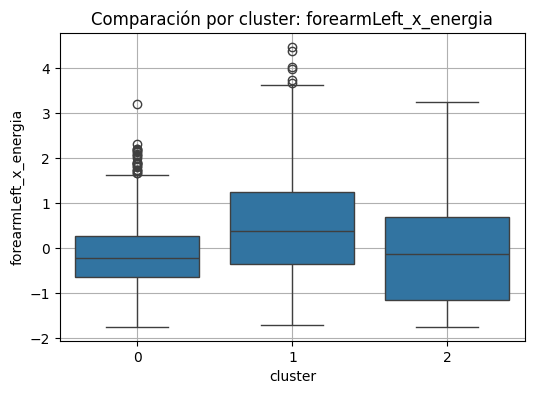

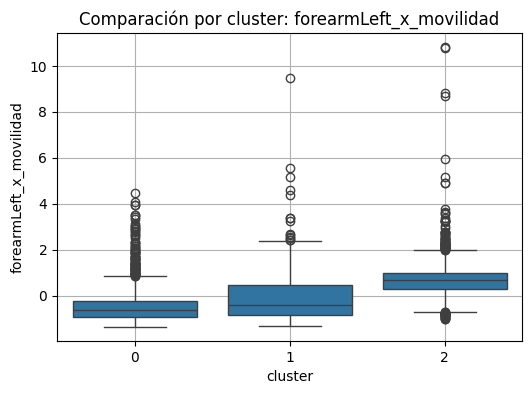

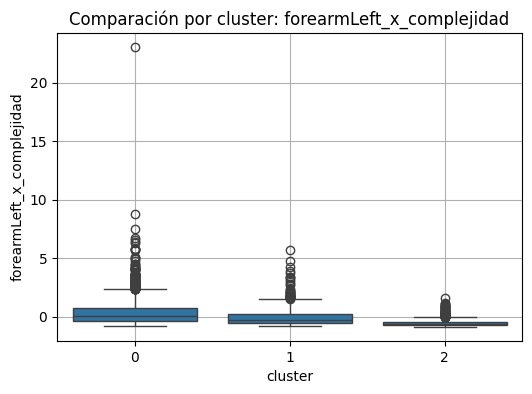

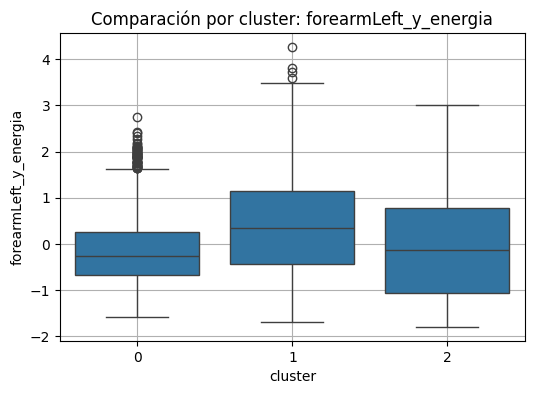

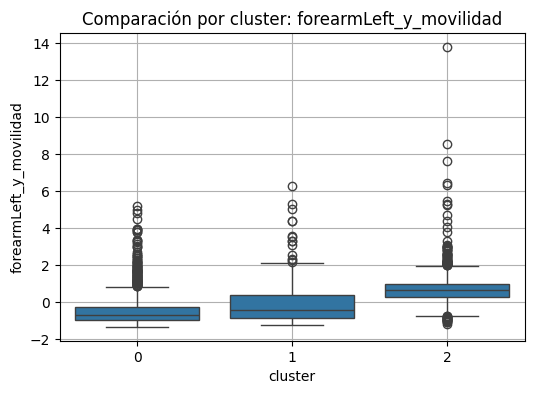

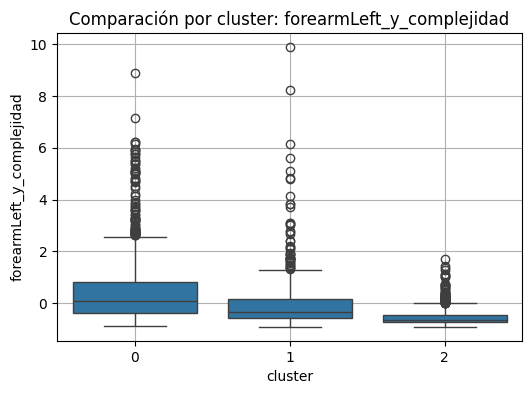

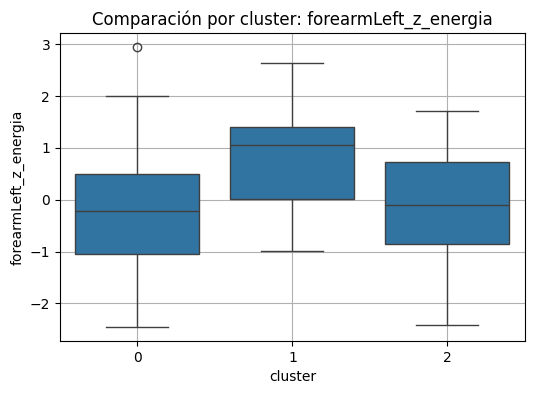

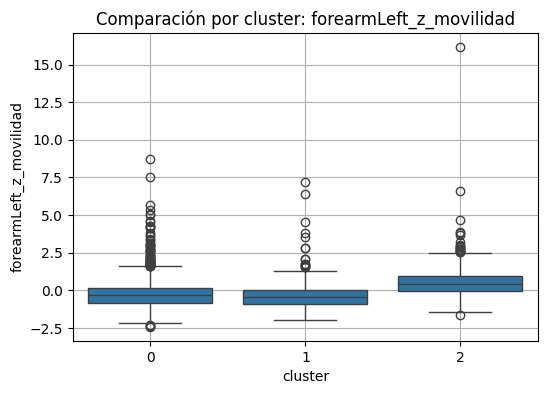

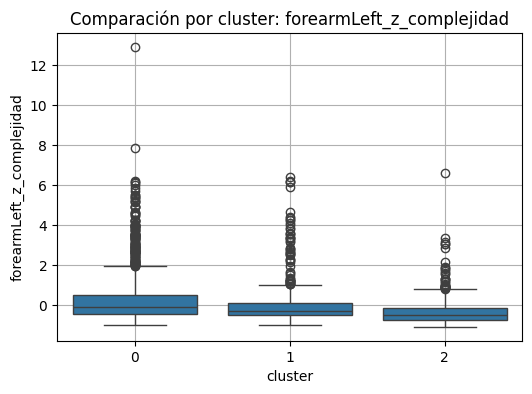

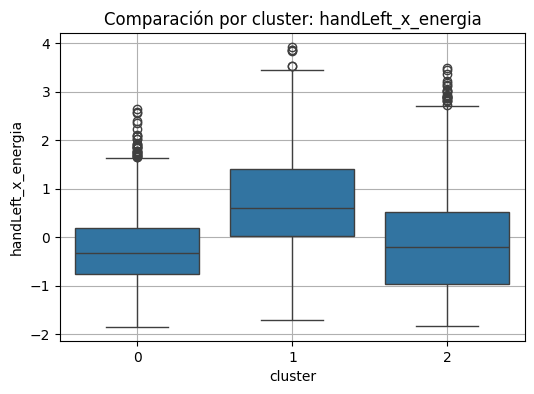

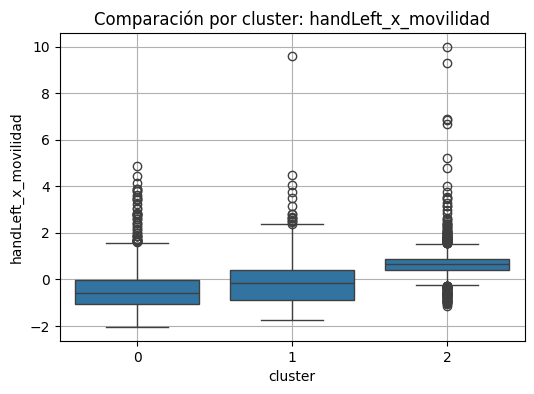

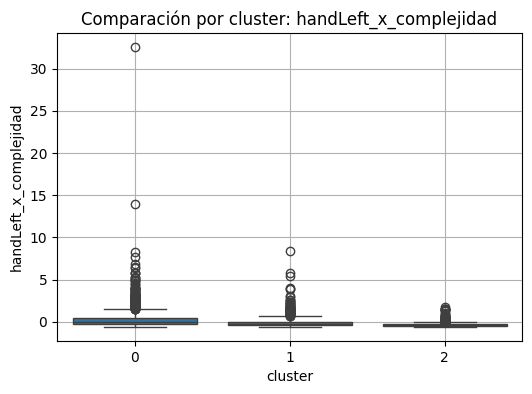

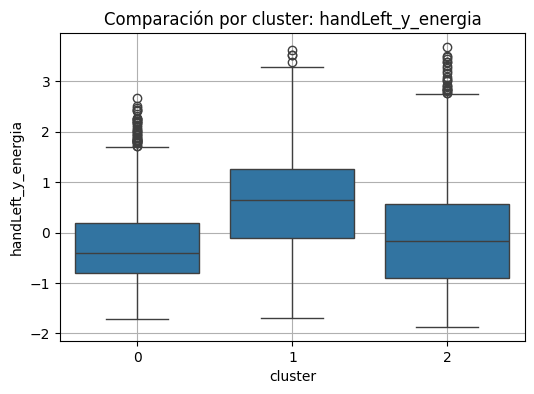

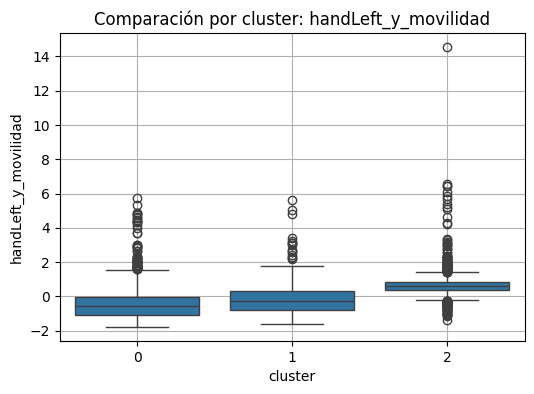

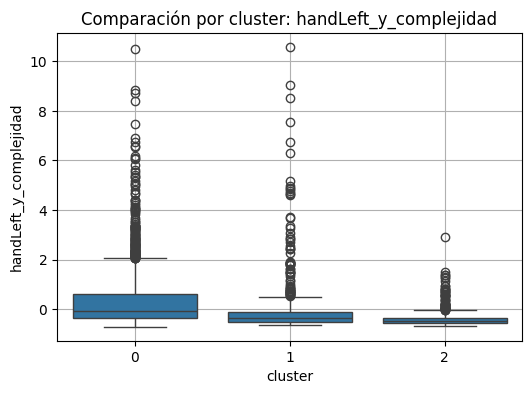

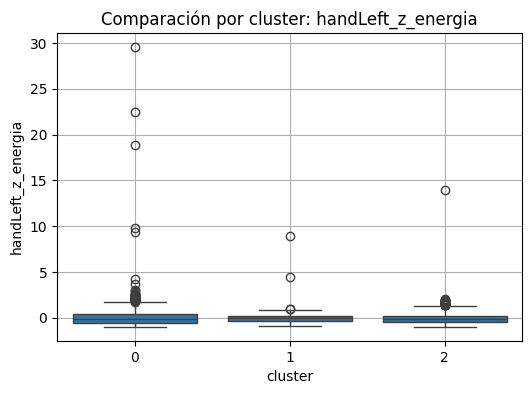

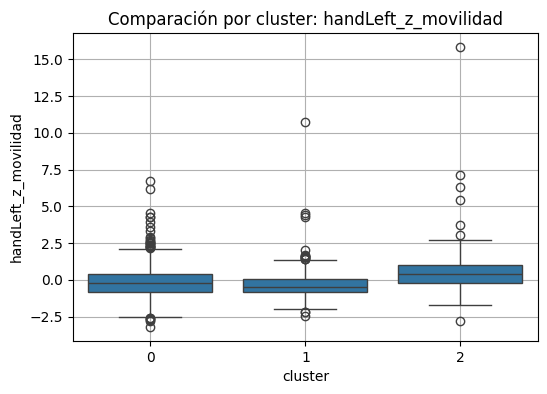

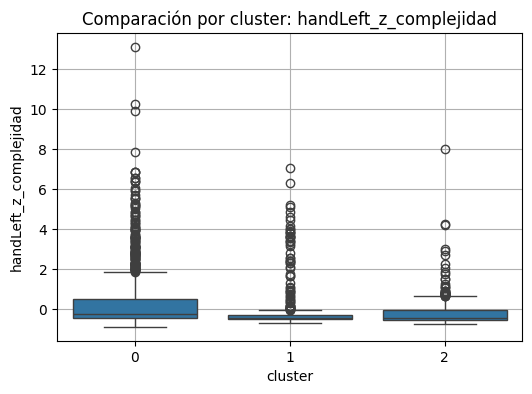

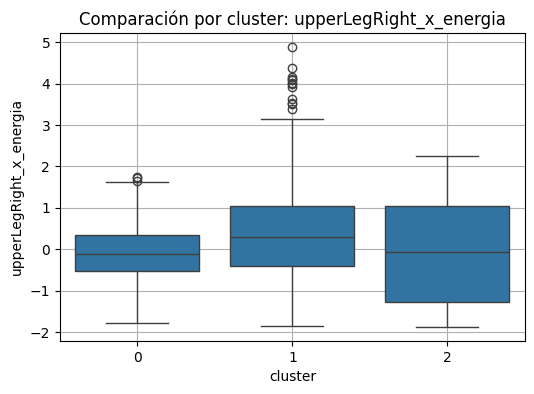

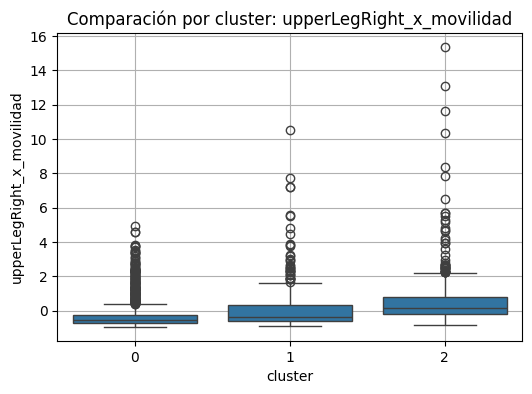

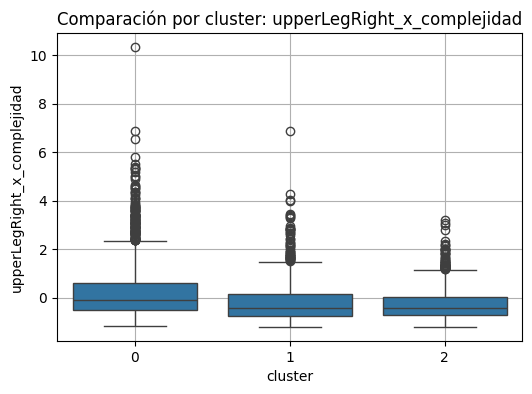

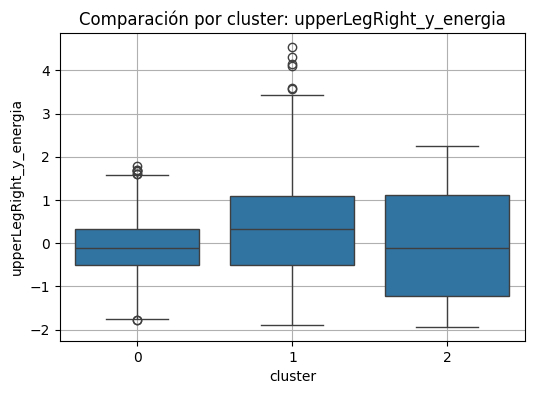

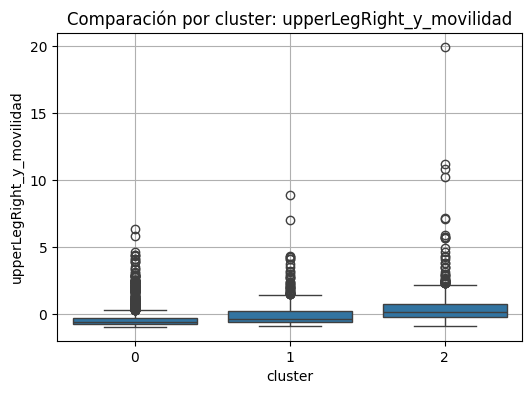

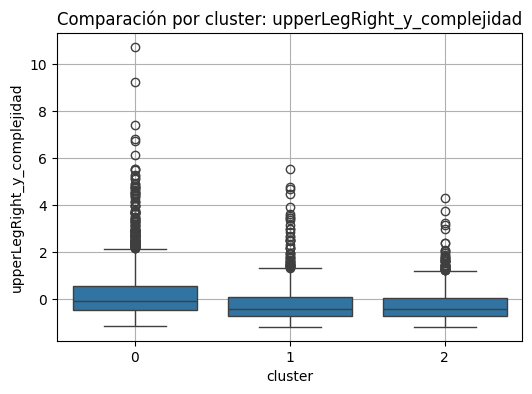

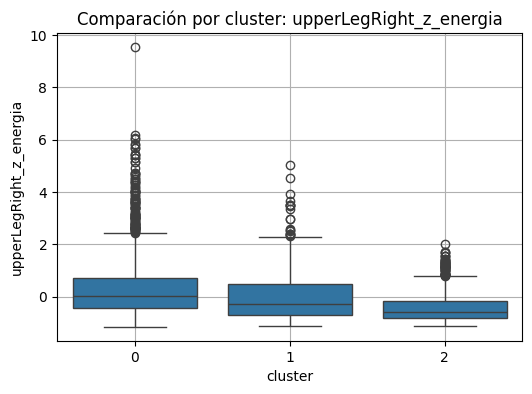

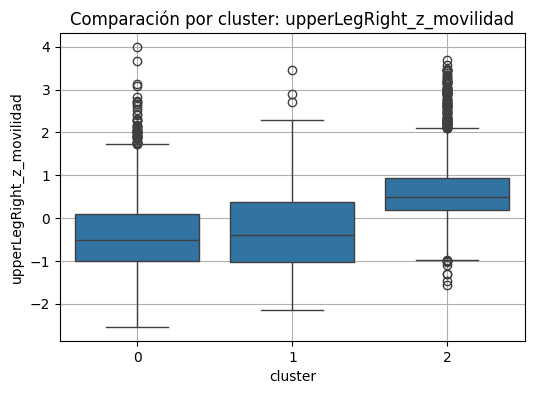

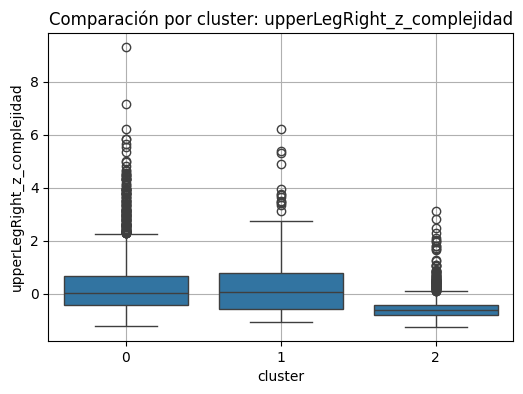

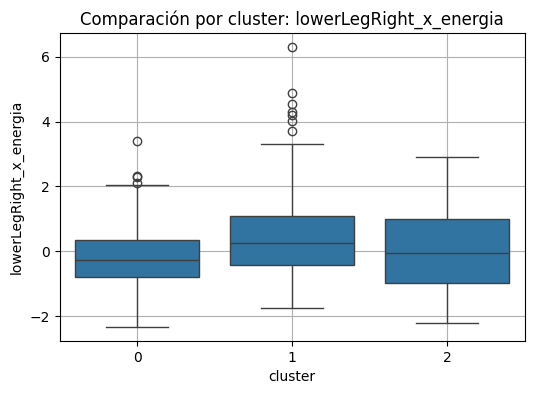

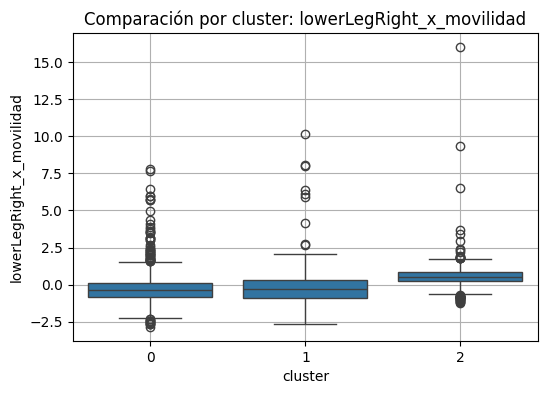

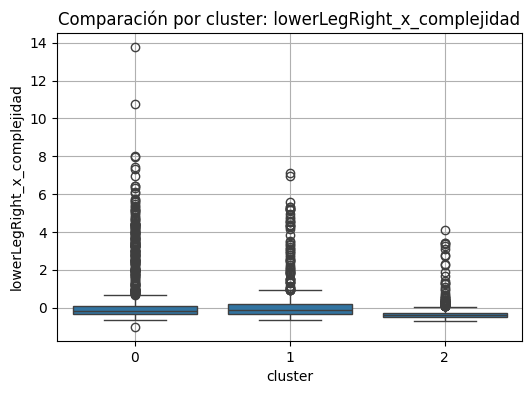

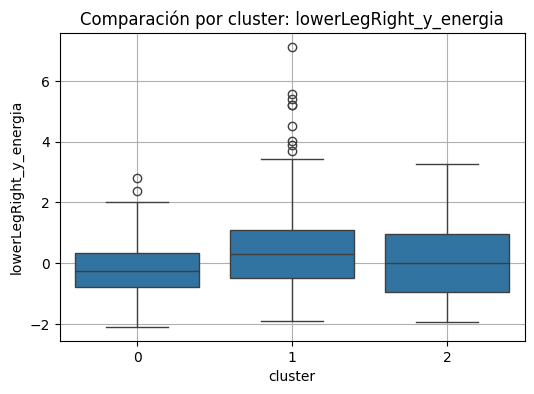

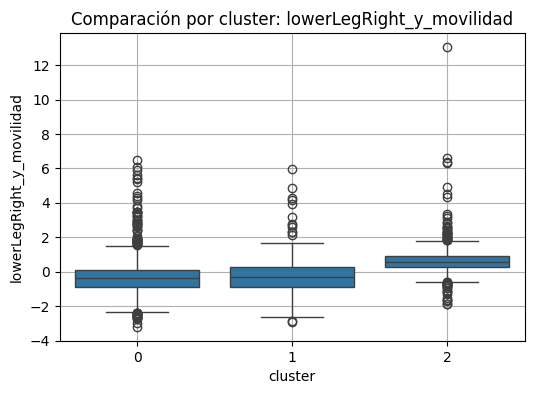

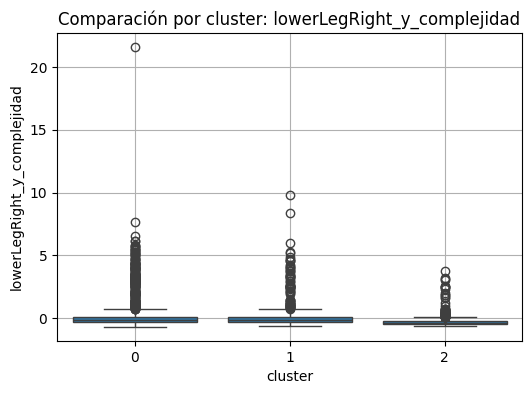

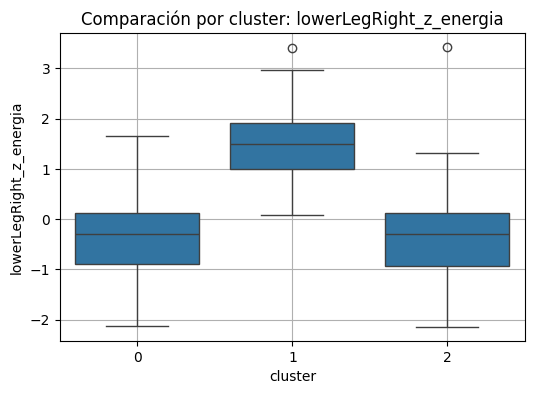

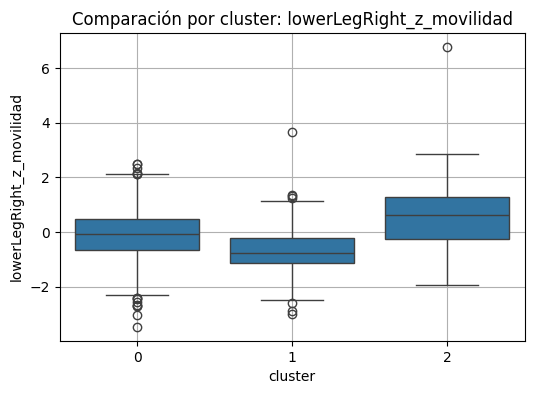

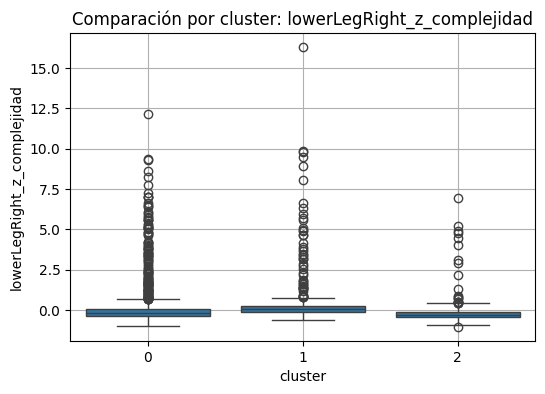

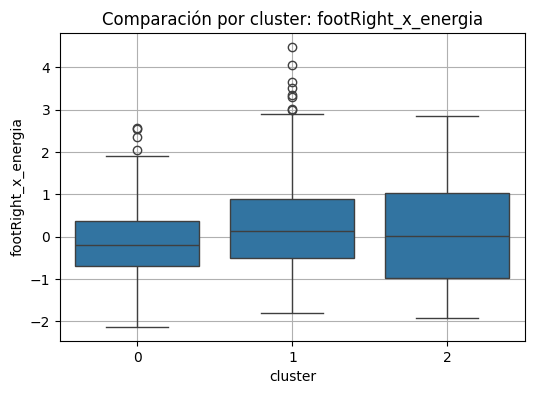

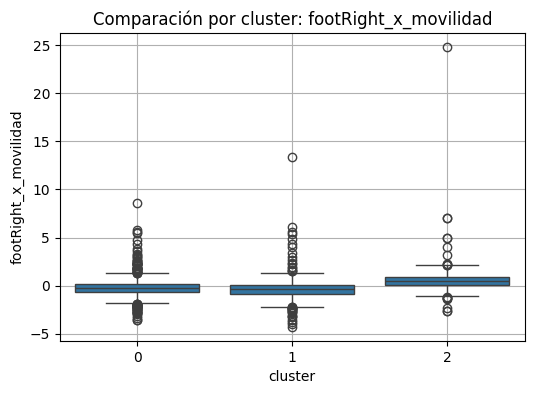

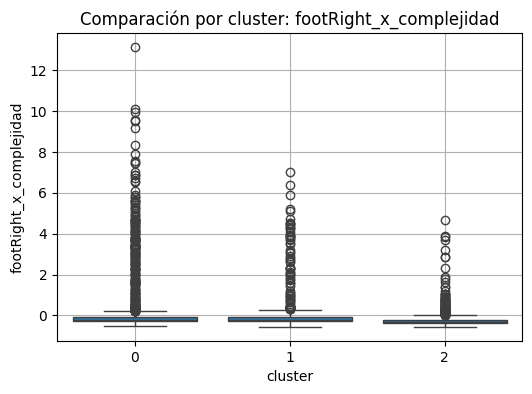

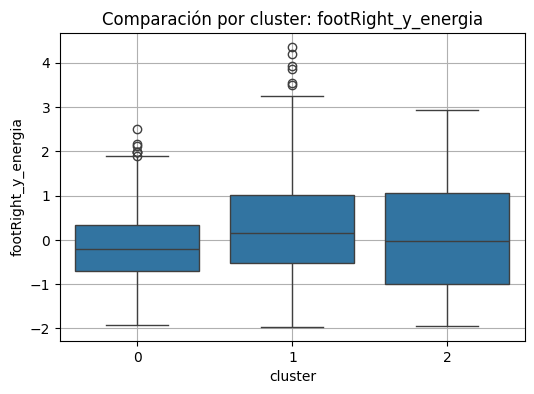

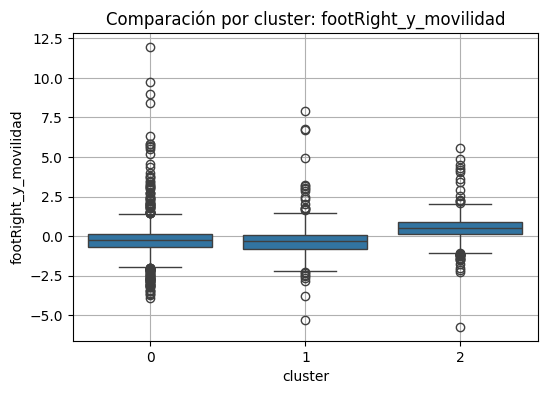

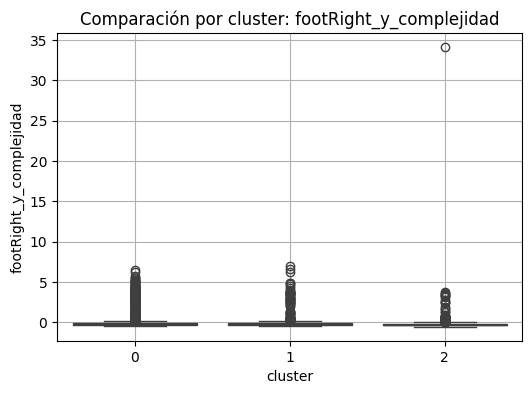

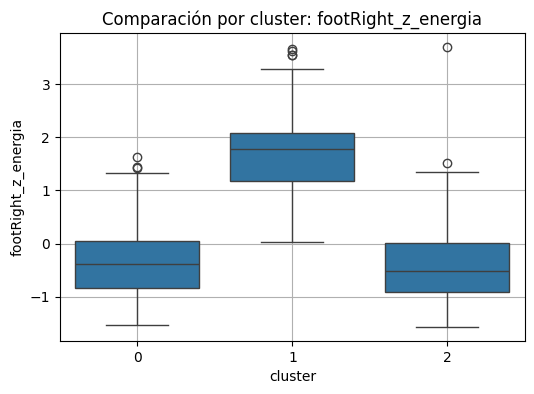

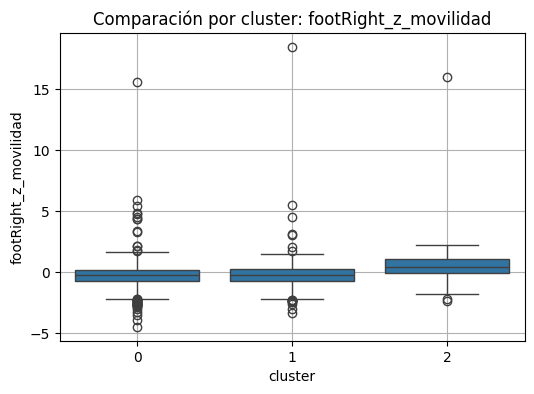

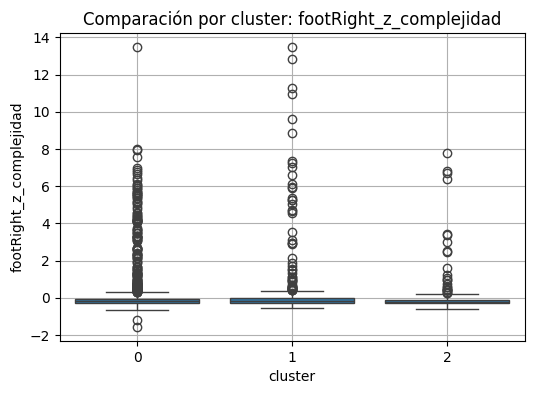

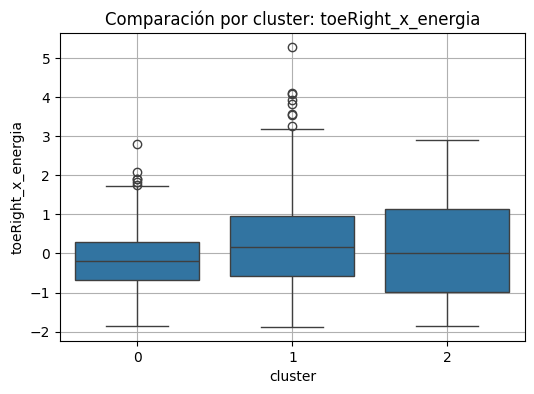

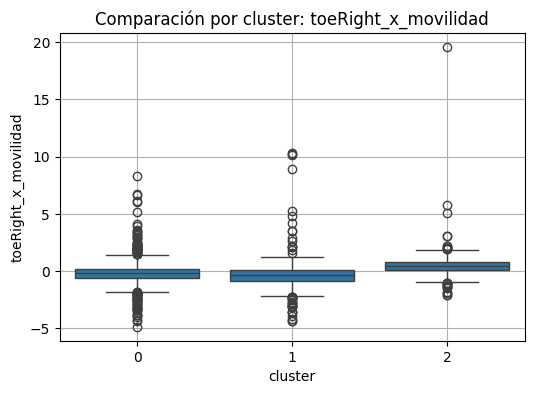

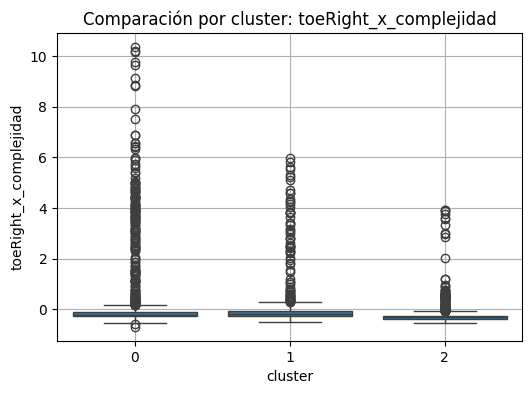

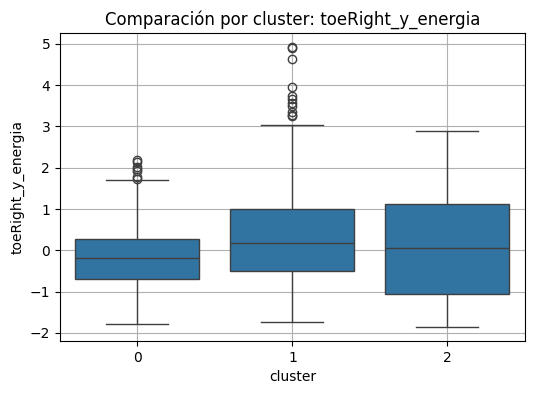

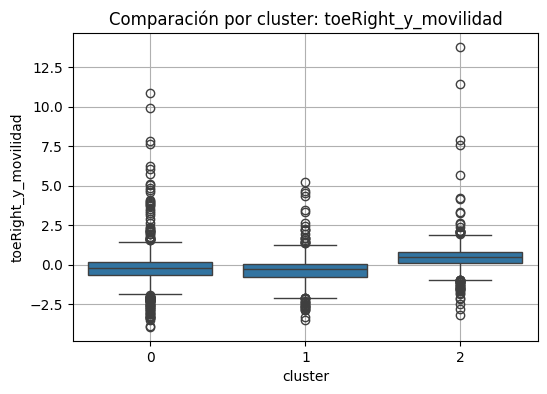

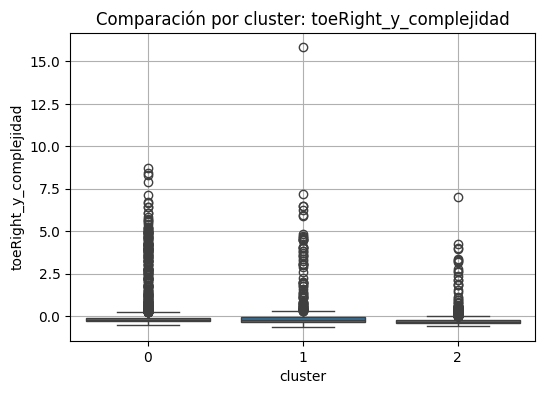

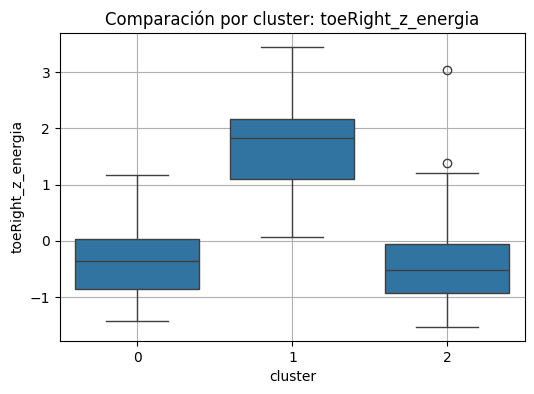

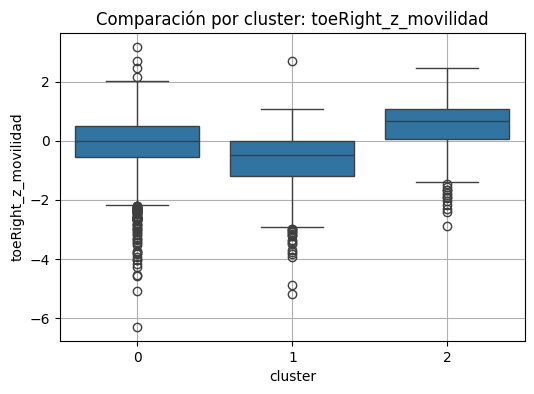

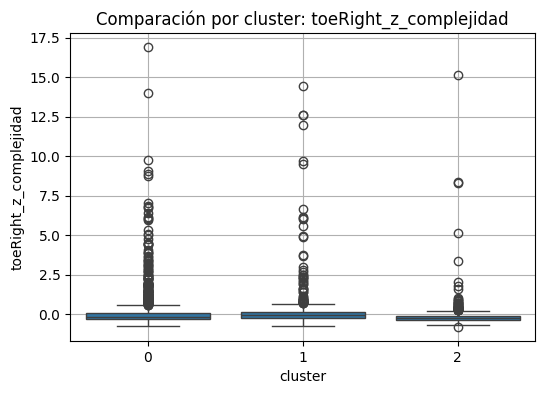

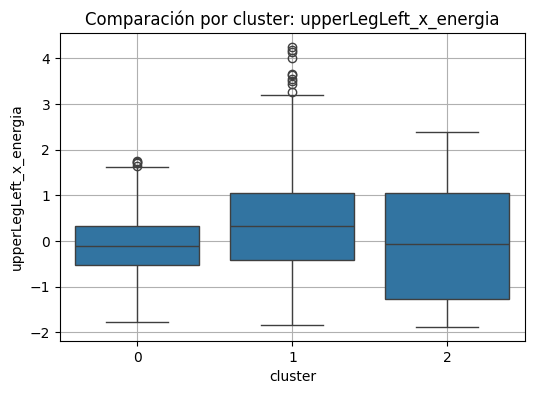

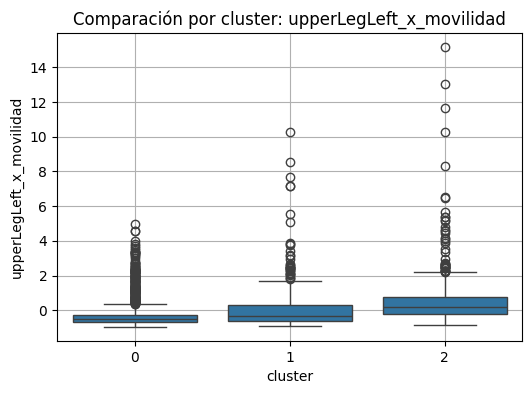

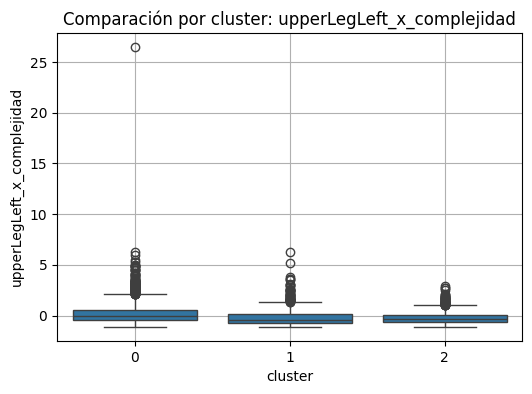

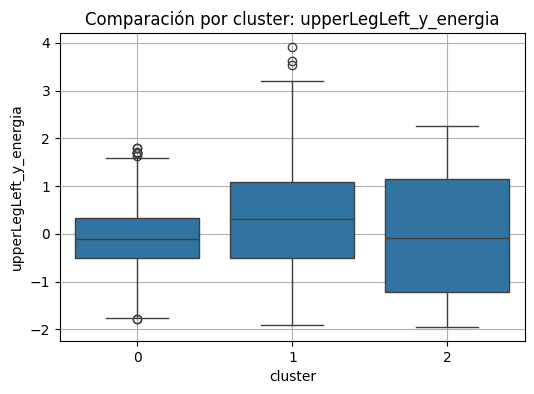

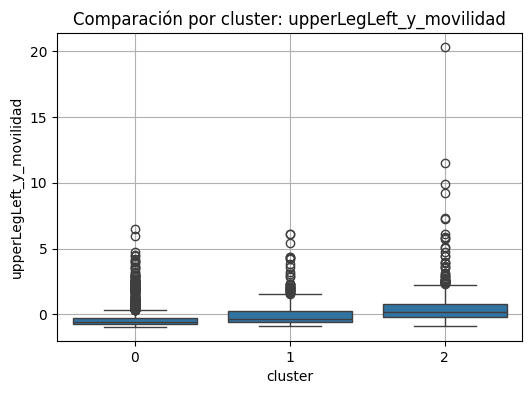

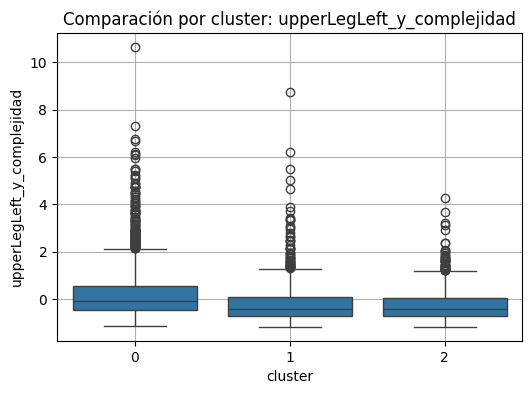

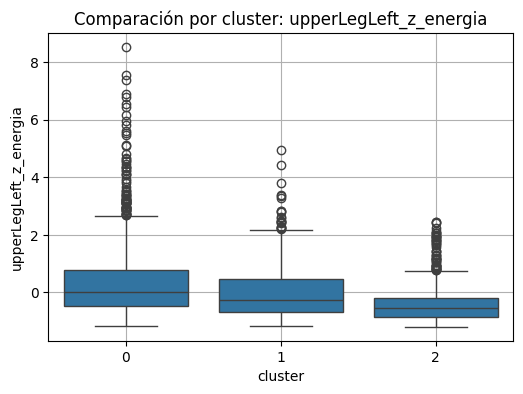

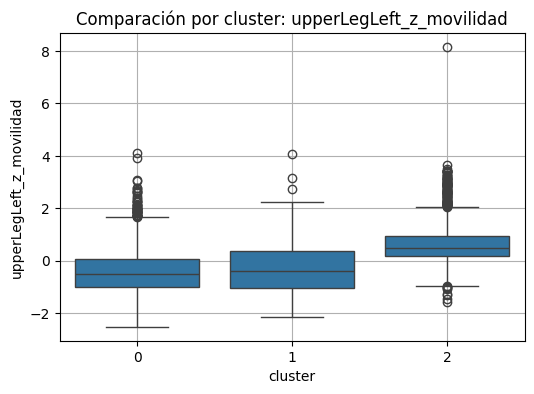

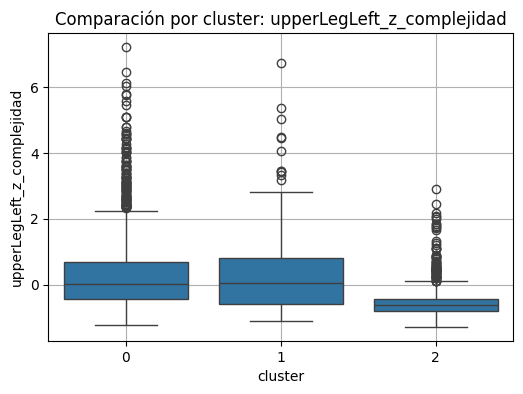

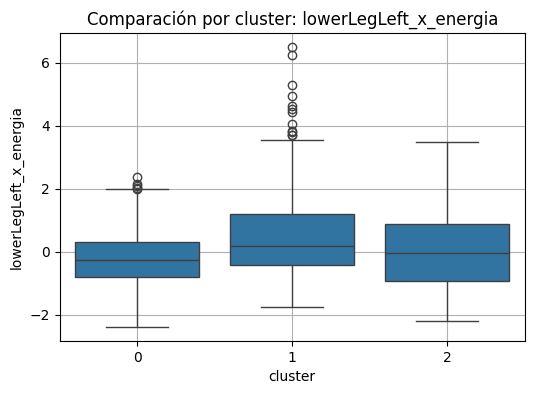

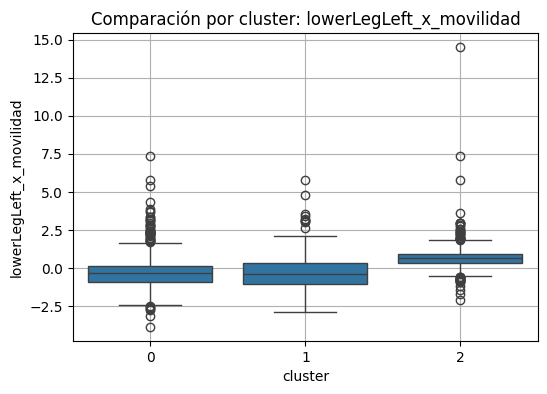

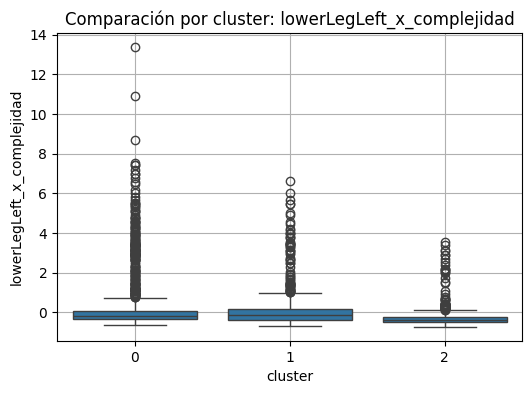

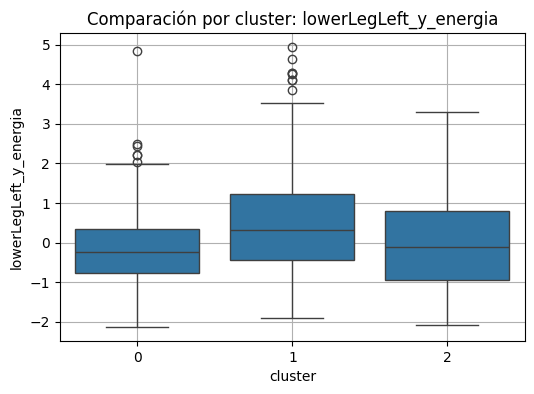

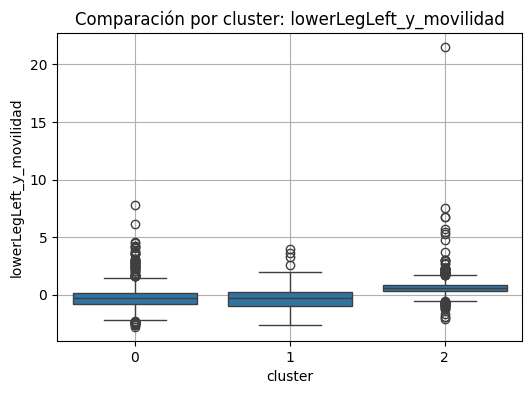

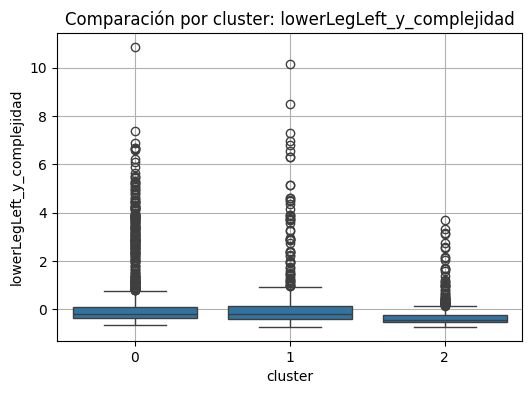

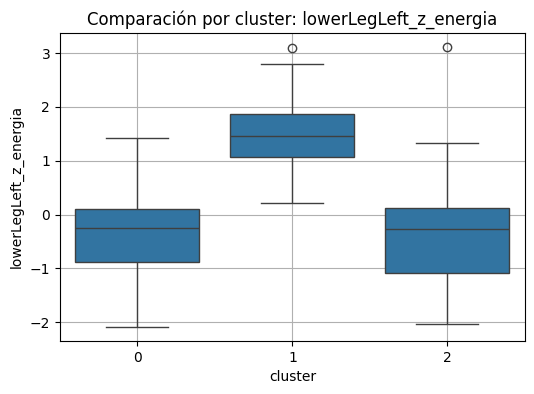

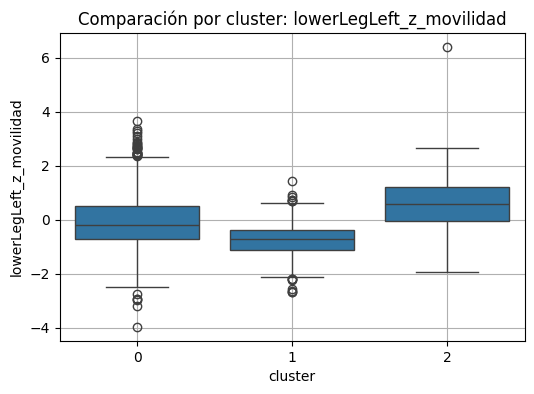

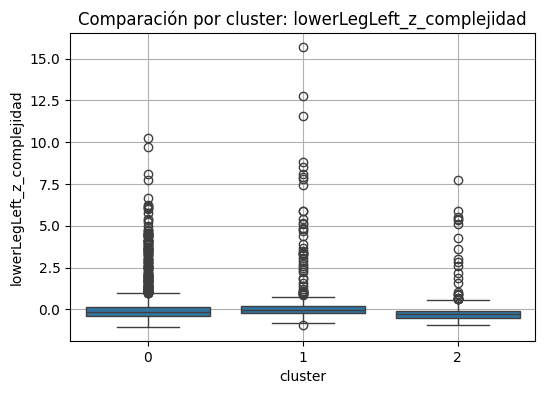

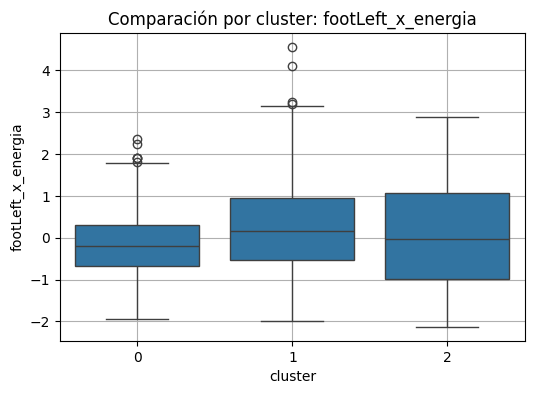

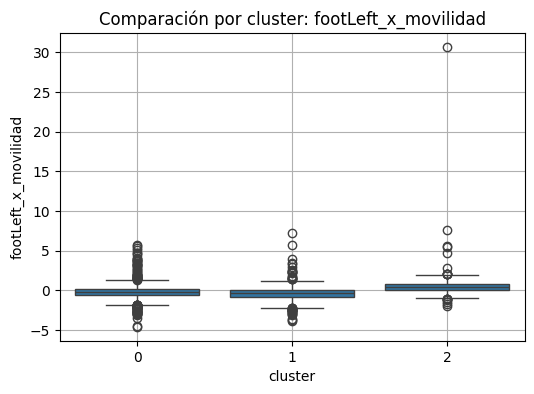

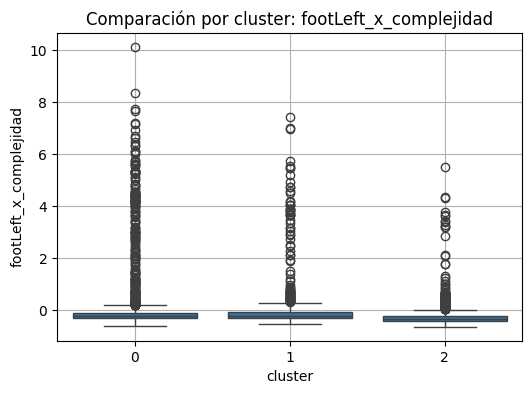

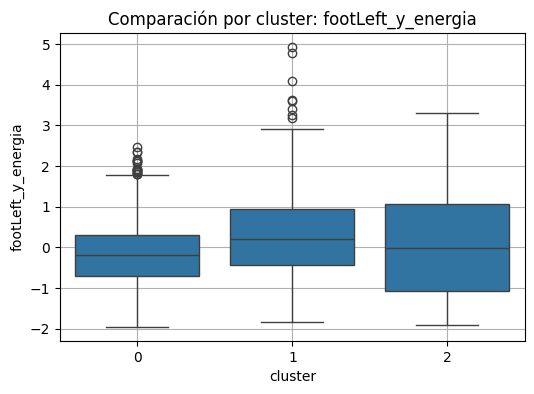

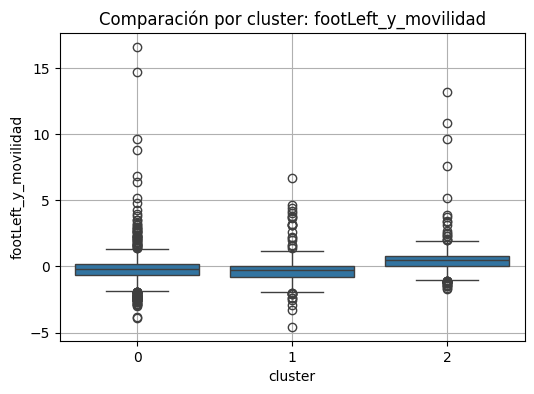

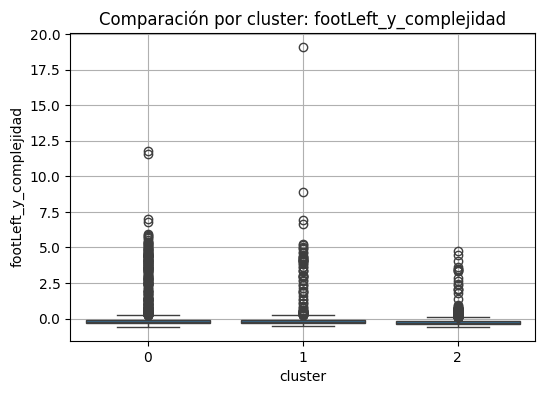

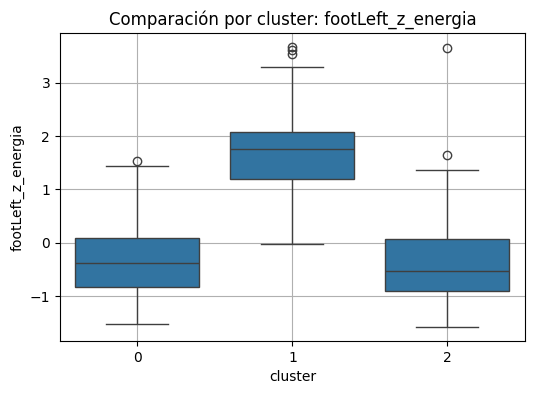

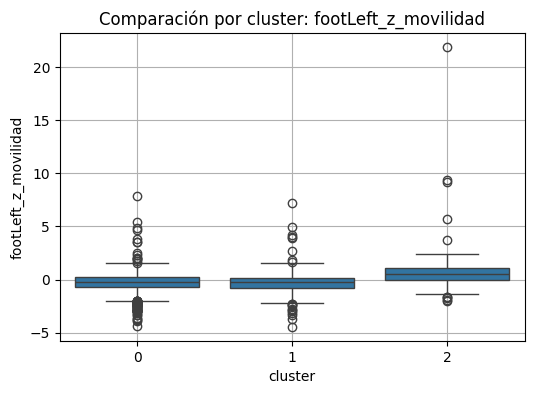

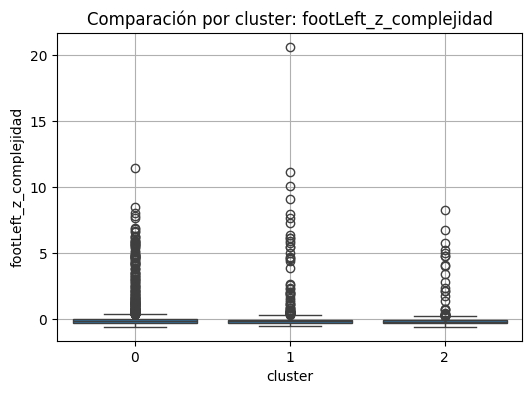

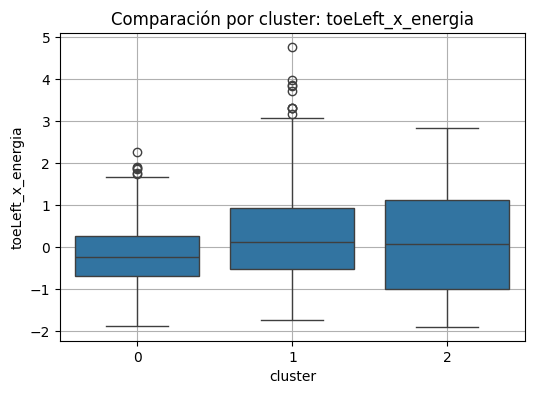

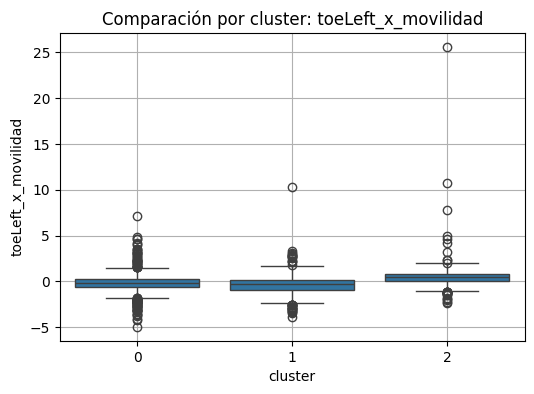

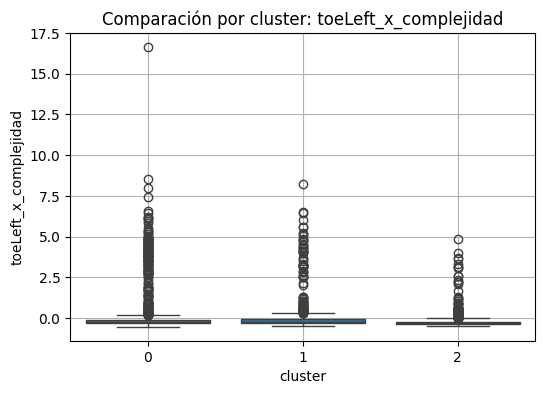

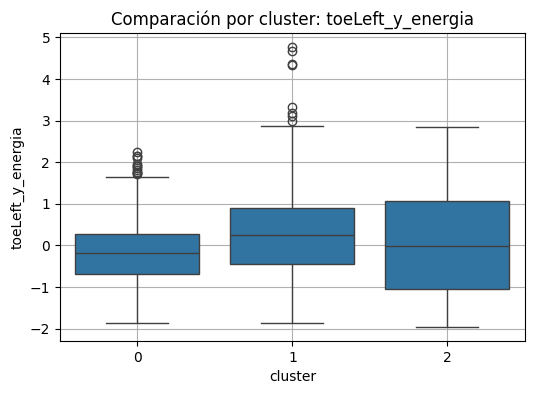

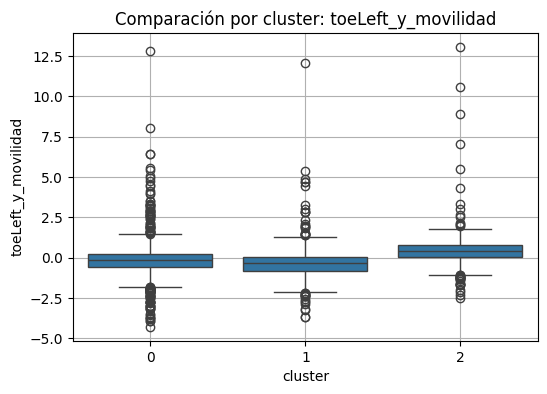

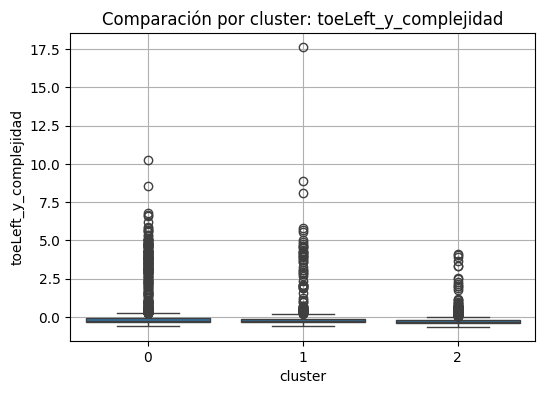

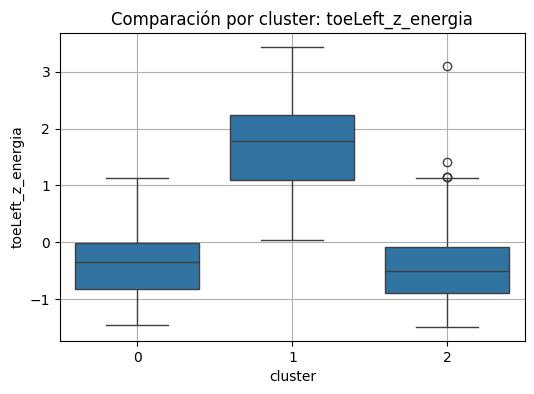

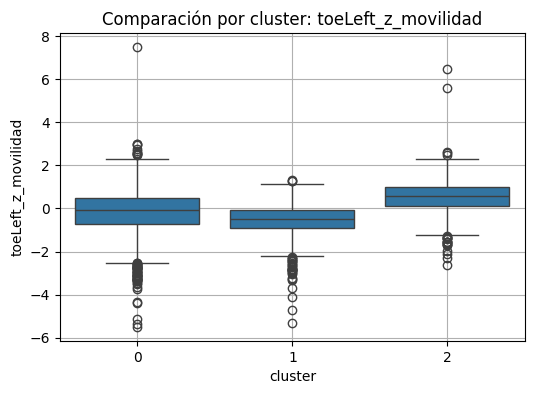

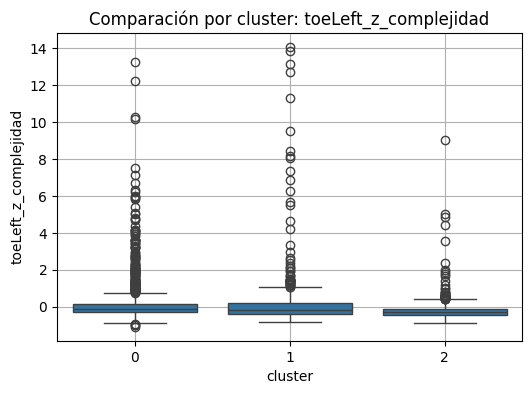

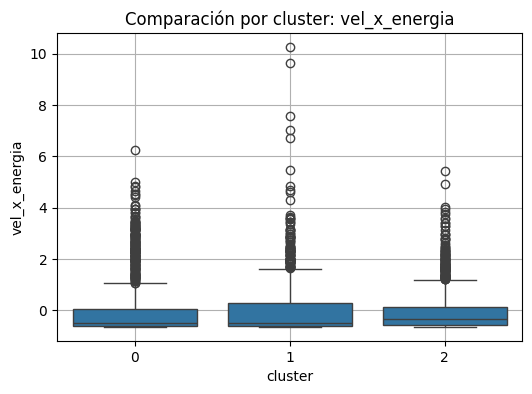

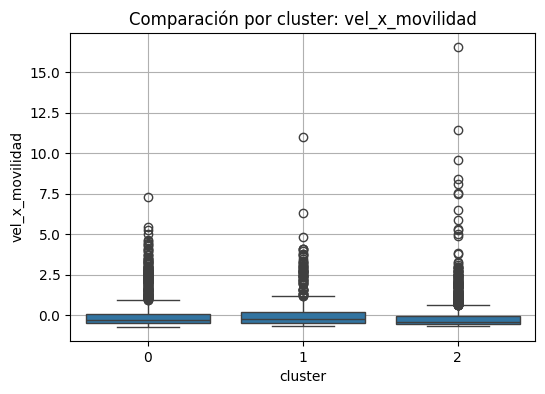

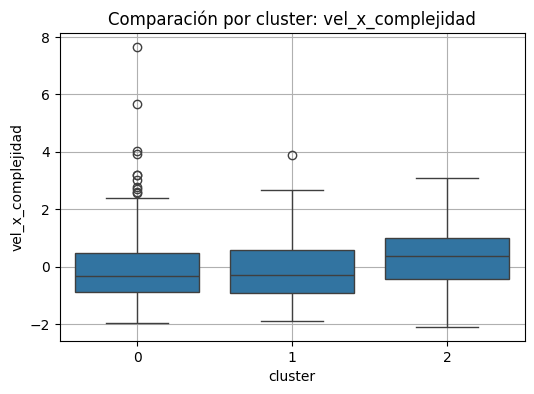

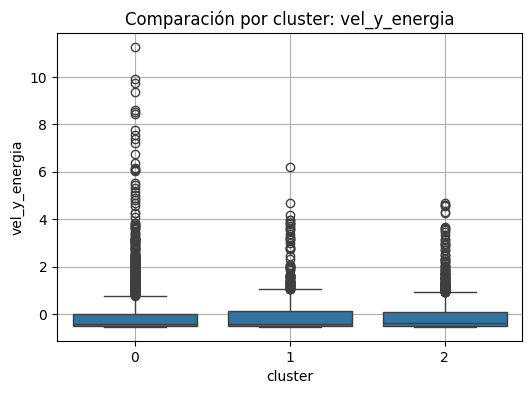

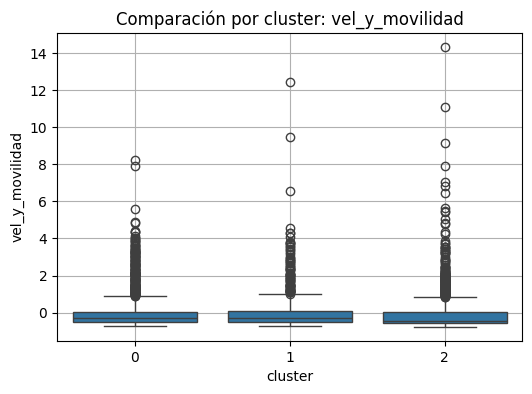

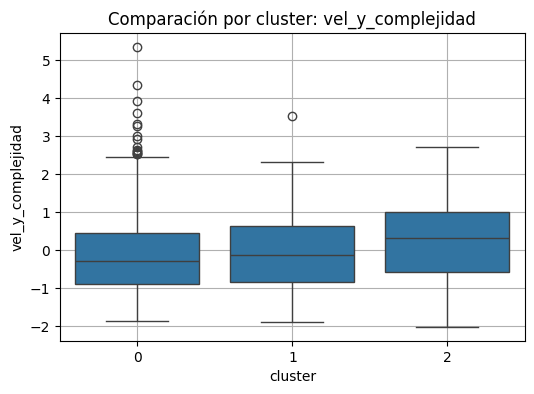

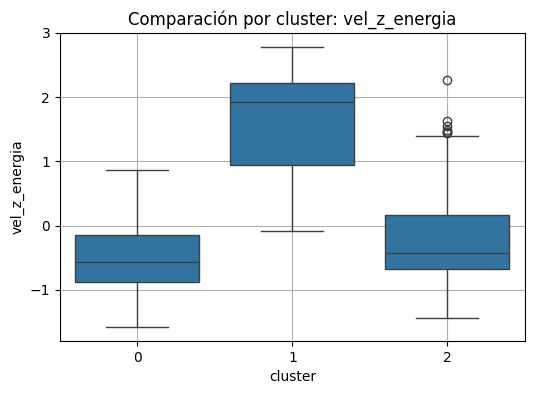

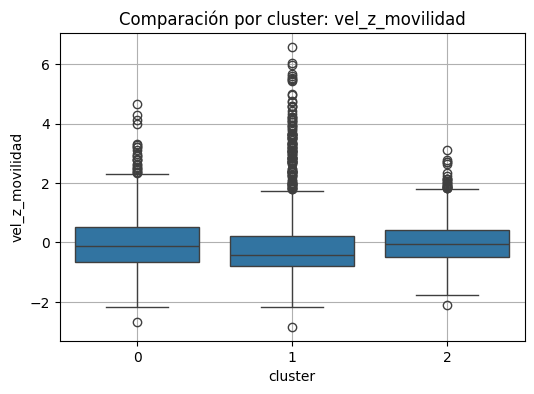

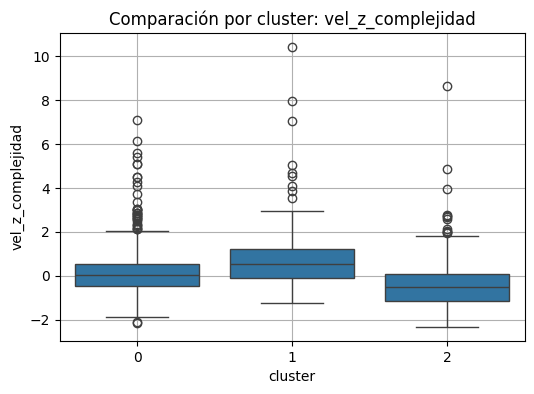

In [15]:
# Elegir características clave para visualizar (puedes ajustar esto)
caracteristicas_a_graficar = [c for c in columnas if 'energia' in c or 'movilidad' in c or 'complejidad' in c]

# Hacer boxplots para cada característica clave por cluster
for feature in caracteristicas_a_graficar:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='cluster', y=feature, data=df_clusters)
    plt.title(f'Comparación por cluster: {feature}')
    plt.grid(True)
    plt.show()


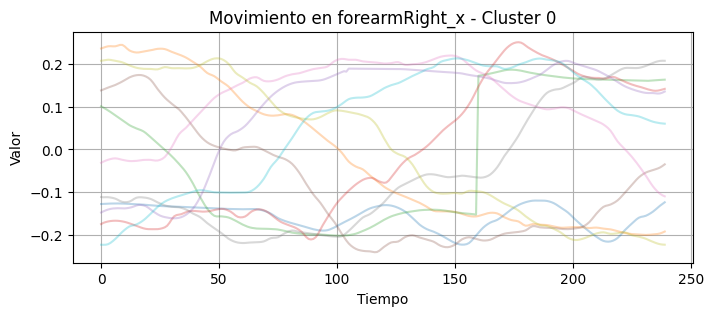

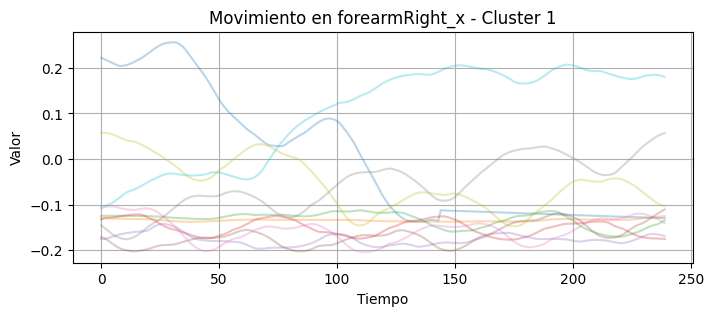

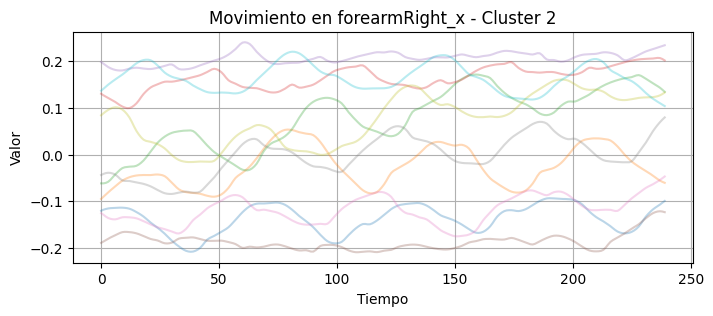

In [17]:
# Visualización del movimiento por cluster para una articulación y eje
articulacion = 'forearmRight_x'  # Ajusta según tus datos

for cl in np.unique(labels):
    ventanas_cluster = [a[i][articulacion].values for i in range(len(labels)) if labels[i] == cl]
    
    plt.figure(figsize=(8, 3))
    for signal in ventanas_cluster[:10]:  # Muestra hasta 10 ejemplos por cluster
        plt.plot(signal, alpha=0.3)
    plt.title(f'Movimiento en {articulacion} - Cluster {cl}')
    plt.xlabel('Tiempo')
    plt.ylabel('Valor')
    plt.grid(True)
    plt.show()